In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
# from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
#import seaborn as sns

from sbi.inference import infer, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import pickle
import scipy.io

from scipy.interpolate import interp1d
import re

from FACTS_Modules.TaskSFCLaw import TaskSFCLaw
from FACTS_Modules.AcousticSynthesis import AcousticSynthesis
import numpy as np
import pdb

from FACTS_Modules.LWPR_Model.lwpr import LWPR
from abc import ABC, abstractmethod

from FACTS_Modules import util
from FACTS_Modules import seutil

import pandas as pd
import seaborn as sns
from scipy import stats
import math


In [2]:
def FACTS(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI_Al.ini'
    # gFile='GesturalScores/KimetalOnlinepert.G'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)
    # print('DEBUGG')
    # Replace the parameter value from ini file
    #pdb.set_trace()
    # try:
    if theta.dim() > 1:
#             pdb.set_trace()
        #print(theta.numel())
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
        config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[0][4].item())
        config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[0][6].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())
        
#         config['TaskStateEstimator']['AUKF_SCmult_for_pert'] = str(theta[0][8].item())
        config['TaskStateEstimator']['AUKF_Rmult_for_pert'] = str(theta[0][8].item())
        config['TaskStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[0][9].item())
        config['TaskStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[0][10].item())

        config['TaskStateEstimator']['AUKF_learning_rate_R'] = str(theta[0][11].item())
        config['TaskStateEstimator']['AUKF_learning_rate_Q'] = str(theta[0][12].item())
        config['TaskStateEstimator']['AUKF_learning_rate_P'] = str(theta[0][13].item())

        config['TaskStateEstimator']['sensory_error_threshold'] = str(theta[0][14].item())
        
        
#         config['ArticStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[0][10].item())
#         config['ArticStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[0][11].item())
        
#         config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[0][8].item())
#         config['ArticStateEstimator']['cc_discount_from_delay'] = str(theta[0][9].item())

#         config['TaskStateEstimator']['cc_decay'] = str(theta[0][10].item())
#         config['TaskStateEstimator']['cc_discount_minimum'] = str(theta[0][11].item())

#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[0][6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[0][7].item())
        
    else:
        #pdb.set_trace()
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
        config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[4].item())
        config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[6].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[7].item())
        
#         config['TaskStateEstimator']['AUKF_SCmult_for_pert'] = str(theta[8].item())
        config['TaskStateEstimator']['AUKF_Rmult_for_pert'] = str(theta[8].item())
        config['TaskStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[9].item())
        config['TaskStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[10].item())

        config['TaskStateEstimator']['AUKF_learning_rate_R'] = str(theta[11].item())
        config['TaskStateEstimator']['AUKF_learning_rate_Q'] = str(theta[12].item())
        config['TaskStateEstimator']['AUKF_learning_rate_P'] = str(theta[13].item())

        config['TaskStateEstimator']['sensory_error_threshold'] = str(theta[14].item())
        
#         config['ArticStateEstimator']['AUKF_Qmult_for_pert'] = str(theta[10].item())
#         config['ArticStateEstimator']['AUKF_Pmult_for_pert'] = str(theta[11].item())
        
#         config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[8].item())
#         config['ArticStateEstimator']['cc_discount_from_delay'] = str(theta[9].item())

#         config['TaskStateEstimator']['cc_decay'] = str(theta[10].item())
#         config['TaskStateEstimator']['cc_discount_minimum'] = str(theta[11].item())

        # Note from Alvince, need to pass this in   
        config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
        config['ArticStateEstimator']['Somato_delay']  = config['SensoryDelay']['Somato_delay'] 

        # Note from Alvince, need to pass this in  for TSE    
        # config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[7].item())
    # except Exception as e:
    #     print(e)
    #     pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    #print(config['ArticStateEstimator']['cc_discount_from_delay'])
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    buffer_size_auditory = int(float(config['SensoryDelay']['Auditory_delay']) / 5)  # default used to be 20
    buffer_size_somato = int(float(config['SensoryDelay']['Somato_delay']) / 5)
    buffer_size = max(buffer_size_auditory, buffer_size_somato)
    
    x_tilde_delaywindow = np.full([buffer_size,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([buffer_size,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+buffer_size,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+buffer_size,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+buffer_size,3])

    #pdb.set_trace()
    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.
        all_adotdot = []

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
                all_adotdot.append(adotdot)
            


        # x1_pred = np.array(model.task_state_estimator.all_internal_x1_prediction)
        # plt.plot(range(x1_pred.shape[0]), x1_pred)
        #pdb.set_trace()
        #P_over_time = np.array(model.task_state_estimator.all_P)
        #plt.plot(P_over_time)
        #plt.show()

        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)

        plot_trial = False 
        if plot_trial:
            plt.figure()
            single_trial_plots('baseline', 
                                    trial, a_tilde_record_alltrials, 
                                    a_tilde_record_alltrials, formant_record_alltrials, 
                                    predict_formant_record_alltrials, x_tilde_record_alltrials, 
                                    [ini, gFile], formants_produced_record_alltrials)
            #pdb.set_trace() # Test if we can print model.
            plt.figure()
            all_Y = np.array(model.task_state_estimator.all_Y)
            plt.plot(all_Y[:,0,:])
            plt.title('Y from TSE Auditory Prediction')

            plt.figure()
            all_y = np.array(model.task_state_estimator.all_y)
            plt.plot(all_y[:,0])
            plt.title('y from TSE Auditory Prediction')
            plt.show()

            #pdb.set_trace()
            a2t_xtilde = np.array(model.task_state_estimator.artic_to_task_xtilde)
            plt.plot(a2t_xtilde)
            plt.title('artic_to_task_xtilde')
            plt.show()

            plt.figure()
            tse_delay_y = np.array(model.task_state_estimator.all_delay_y)
            plt.plot(tse_delay_y[:,0])
            plt.title('tse_delay_y')
            plt.show()

            plt.figure()
            all_formant_with_noise = np.array(model.task_state_estimator.all_formant_with_noise)
            plt.plot(all_formant_with_noise[:,0])
            plt.title('all_formant_with_noise')
            plt.show()


            plt.figure()
            all_X1 = np.array(model.task_state_estimator.all_X1)
            plt.plot(all_X1[:,:,0])
            plt.title('X1 into TSE Aud Predict')
            plt.show()

            plt.figure()
            all_adotdot = np.array(all_adotdot)
            print(all_adotdot.shape)
            plt.plot(all_adotdot)
            plt.title('adotdot')
            plt.show()

            plt.show()

        #print(f"formant_record_alltrials {formant_record_alltrials}")
        #print(f"formants_produced_record_alltrials {formants_produced_record_alltrials}")
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return torch.from_numpy( formants_produced_record_alltrials[:,:,0].squeeze() )



def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


# Model.py runs all major FACTS modules. Modules that are 
# carried out in each time step are listed in the method 
# "run_one_timestep." model_factory builds FACTS based on 
# the model architecture specified in config files. 

# Under "Hierarchical_xdotdot," for example, the task 
# state estimator type is defined as lwpr. 

def model_factory(config):
    if 'ModelArchitecture' in config.keys():
        if config['ModelArchitecture']['architecture'] == 'classic': return Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical': return Hierarchical_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_articsfcupdate': return Hierarchical_ArticSFCUpdate_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_xdotdot': return Hierarchical_xdotdot(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_JacUpdateDebug': return Hierarchical_JacUpdateDebug(config)
    return Model(config)


# parent class
class Model():
    def __init__(self,model_configs):
        self.task_sfc_law = TaskSFCLaw()
        self.artic_sfc_law = self.artic_sfc_law_factory(model_configs['ArticSFCLaw'])
        self.artic_kinematics = self.artic_kinematics_factory(model_configs)
        self.acoustic_synthesis = AcousticSynthesis(model_configs['AcousticSynthesis'])
        self.auditory_perturbation = self.auditory_perturbation_factory(model_configs)
        self.sensory_system_noise = self.sensory_system_noise_factory(model_configs)
        self.sensory_system_delay = self.sensory_system_delay_factory(model_configs)
        R_Auditory = self.sensory_system_noise.get_R_Auditory()
        R_Somato = self.sensory_system_noise.get_R_Somato()
        self.artic_state_estimator = self.ase_factory(model_configs,R_Auditory,R_Somato)
        self.task_state_estimator = self.tse_factory(model_configs['TaskStateEstimator'],R_Auditory,R_Somato)
        #self.state_estimator = self._state_estimator_factory(model_configs,R_Auditory,R_Somato)
        
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, y_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,formants_noise,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde)

        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot, y_hat
        
    # Factory methods
    def artic_sfc_law_factory(self,configs):
        model_type = configs['model_type']
        #print('Artic SFC Law Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.ArticSFCLaw import ArticSFCLaw_LWPR_noupdate
            artic_sfc_law = ArticSFCLaw_LWPR_noupdate(configs)
        return artic_sfc_law
    
    def artic_kinematics_factory(self,model_configs):
        if 'ArticKinematics' in model_configs.sections():
            from FACTS_Modules.ArticKinematics import ArticKinematics_Noise
            artic_kinematics = ArticKinematics_Noise(model_configs['ArticKinematics'])
        else:
            from FACTS_Modules.ArticKinematics import ArticKinematics
            artic_kinematics = ArticKinematics()
        return artic_kinematics
    
    def sensory_system_noise_factory(self,model_configs):
        if 'SensoryNoise' in model_configs.sections():
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise
            sensory_system_noise = SensorySystemNoise(model_configs['SensoryNoise'])
        else:
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise_None
            sensory_system_noise = SensorySystemNoise_None()
        return sensory_system_noise

    def sensory_system_delay_factory(self,model_configs):
        if 'SensoryDelay' in model_configs.sections():
            from FACTS_Modules.SensorySystemDelay import SensorySystemDelay
            sensory_system_delay = SensorySystemDelay(model_configs['SensoryDelay'])
        return sensory_system_delay

    def auditory_perturbation_factory(self,model_configs):
        if 'AudPerturbation' in model_configs.sections():
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation
            auditory_perturbation = AuditoryPerturbation(model_configs['AudPerturbation'])
        else:
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation_None
            auditory_perturbation = AuditoryPerturbation_None()
        return auditory_perturbation
    
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':
                from FACTS_Modules.ArticStateEstimator import ASE_UKF_Classic
                artic_state_estimator = ASE_UKF_Classic(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Classic
            task_state_estimator = TSE_LWPR_Classic(tse_configs)
        return task_state_estimator
    
class Hierarchical_Model(Model):
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':   
                artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)             
                # if 'Somato_sensor_scale_est' in model_configs['ArticStateEstimator']:
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier_NoiseEst
                #     artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
                #     #print('got the right ASE')
                # else:    
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier
                #     artic_state_estimator = ASE_UKF_Hier(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        #print('Inside the tse factory')
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier
            task_state_estimator = TSE_LWPR_Hier(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
    
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, a_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde,formants_noise,i_frm,catch)
        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot

        

class Hierarchical_xdotdot(Hierarchical_Model):
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
            # if 'Auditory_sensor_scale_est' in tse_configs:
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_NoiseEst
            #     task_state_estimator = TSE_LWPR_Hier_NoiseEst(tse_configs,R_Auditory,R_Somato)
            #     #print('got the right TSE')
            # else:  
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_xdotdot
            #     task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
     
    def run_one_timestep(self, x_tilde_delaywindow, a_tilde_delaywindow, prev_a_actual, somato_record, formant_record, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(x_tilde_delaywindow[0],GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, a_tilde_delaywindow[0],ART,i_frm,PROMACT,ms_frm)
        if type(adotdot) != np.ndarray or any(np.isnan(adotdot)):
            formants_produced = np.array([-1, -1, -1], dtype= np.float32)
            a_actual = [-10000,-10000,-10000]
            y_hat = np.array([-1, -1, -1], dtype= np.float32)
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

#         try:
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        #print("a_actual",a_actual)
        formants = self.acoustic_synthesis.run(a_actual)
        #print("Maeda output",formants)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, somato_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        formants_noise, somato_noise, formant_record, somato_record = self.sensory_system_delay.run(ms_frm, i_frm,formants_noise,somato_noise,formant_record,somato_record)
        prev_a_tilde = a_tilde_delaywindow[0]

        #print("x_tilde",x_tilde_record[i_frm])
        #print("x_tilde",x_tilde_record[119])
        a_tilde, a_hat = self.artic_state_estimator.run(a_tilde_delaywindow,adotdot,somato_noise,ms_frm,i_frm,catch)
        #pdb.set_trace()
        #print("i_frm",i_frm)
        #print("atilde",a_tilde)
        x_tilde, y_hat = self.task_state_estimator.run(a_tilde_delaywindow,formants_noise,i_frm,catch,xdotdot)
        #print('y_hat', y_hat)

        #print("form_hat",y_hat_record[i_frm+2])
        #a_tilde_record[i_frm+1] = a_tilde 
        #x_tilde_record[i_frm+1] = x_tilde
        a_tilde_delaywindow = np.insert(a_tilde_delaywindow[0:-1,:],0,a_tilde,0) #add the most recent frame to 0 and remove the oldest frame.
        x_tilde_delaywindow = np.insert(x_tilde_delaywindow[0:-1,:],0,x_tilde,0)
        #print("estimator end----------------------------------------------------------------------------------------------")

        formants_produced = formants
        return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced
    
#         except Exception as e:
#             print(e)
#             pdb.set_trace()
#             formants_produced = np.array([-1, -1, -1], dtype= np.float32)
#             a_actual = [-10000,-10000,-10000]
#             y_hat = np.array([-1, -1, -1], dtype= np.float32)
#             return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

class TaskStateEstimator(ABC):
    def update(self,catch):
        print('TSE Update not implemented')

class TSEClassicInterface():
    @abstractmethod
    def run(self,a_tilde):
        raise NotImplementedError
        
class TSEHierInterface():
    @abstractmethod
    def run(self,a_tilde,formants):
        raise NotImplementedError
        
class TSE_LWPR(TaskStateEstimator):
    def __init__(self,tse_configs):
        self.Taskmodel = LWPR(tse_configs['Task_model_path'])
        self.Taskmodel.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Taskmodel.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Taskmodel.final_lambda = float(tse_configs['lwpr_final_lambda'])
    
#Task Estimator in Parrell et al. (2019)
#which is a simple transformation of the artic state
class TSE_LWPR_Classic(TSE_LWPR,TSEClassicInterface):
    def __init__(self,tse_configs):
        super().__init__(tse_configs)
    def run(self,a_tilde):
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        #pdb.set_trace()
        #print("xtilde", x_tilde)
        return x_tilde

#Task Estimator that receives auditory feedback
#and uses UKF (or AUKF). However, this task
#estimator does not use the task efference copy (xdotdot)
class TSE_LWPR_Hier(TSE_LWPR,TSEHierInterface):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs)
        self.R = np.diag(R_Auditory)

        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(tse_configs['process_scale'])
        covariance_scale = float(tse_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.x_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.x_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.x_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        self.feedbackType = tse_configs['feedback_type']

        # create state covariance matrix P
        self.P = covariance_scale*np.eye(gv.x_dim*2);

        #self.nulltaskmodel = LWPR(tse_configs['Task_model_path']) #3/17/22 change
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1 #-1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        #ki= 3-(gv.x_dim*2)                                #tunable
        ki= -11#-11                              #default, tunable        
        lam=(alpha**2)*((gv.x_dim*2)+ki)-(gv.x_dim*2)                    #scaling factor
        c=(gv.x_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.x_dim*2))+0.5/c)           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance        
        self.c=np.sqrt(c)
        
        self.senmem = []
        if tse_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.taskmem = []
        self.Aud_model = LWPR(tse_configs['Formant_model_path'])
        self.Aud_model.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Aud_model.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Aud_model.final_lambda = float(tse_configs['lwpr_final_lambda'])

        self.defQ = self.Q
        self.defR = self.R
        self.defP = self.P

        self.APET = float(tse_configs['F1_Prediction_Error_Threshold'])
        
        if tse_configs['AUKF'] == 'True':
            self.AUKF = True
            self.AUKFmultFactor = string2dtype_array(tse_configs['AUKFmultFactor'], 'float32')
        else: 
            self.AUKF = False

        # self.artic_to_task_xtilde = []

    def run(self,a_tilde,formant_noise,i_frm,catch):
        
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        # self.artic_to_task_xtilde.append(x_tilde)

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        if type(X) != np.ndarray:
            pdb.set_trace()

        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q) #transformation of x_tilde (propagation)

        if self.feedbackType == 'nofeedback' or catch or i_frm < 10:
            x = x1
            self.P = P1
        else:
            Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
            z = formant_noise
            #print("predict: ", y)
            #print("actual: ", z)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
             
            #StateUpdate Eq 7, 
            x = x1 + DeltaX
            # print('internal TSE state estimate ', x1)

            # print(f'i_frm= {i_frm}, DeltaX =  {DeltaX}')
            self.P= P1 - DeltaCov #covariance update

            self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x,a_tilde,self.APET)
            if self.learn: # current version has no online compensation during adapt
                x = x1
                self.P = P1

        x_tilde = x
        #x_hat = x1
        return x_tilde
    
    def TaskStatePredict(self,X,Wm,Wc,n,R):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        for k in range(L):
            #jac = Taskmodel.predict_J(X[0:gv.a_dim,k])
            #Y[:,k] = np.append(jac[0],np.matmul(jac[1],X[gv.a_dim:2*gv.a_dim,k]))
            Y[:,k] = X[0:gv.x_dim*2,k] # 1 to 1 relationship, because this is just getting unscented transformation.
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
        
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1 
        
    def update(self,catch):
        if self.learn and not catch == 2:
            #self.Aud_model = seutil.UpdateAuditoryPrediction(self.Aud_model,self.taskmem,self.senmem)
            self.taskmem, self.Taskmodel = seutil.UpdateTaskPrediction(self.Taskmodel,self.taskmem,self.senmem)
            #print(Taskmodel.predict(np.array([0.0631606,-0.13590163,0.0706008,0.04309455,-0.00238945,0.00098181])))
            #print(len(self.senmem))
            #self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction('audOnly',self.Aud_model,0,self.senmem) 
            #print(self.Aud_model.predict(np.array([15.78746351,14.68617247,18.93449447,17.52760635,29.64618912,14.33349587,13.04996568])))     
        
        self.taskmem = []
        self.senmem = []

#Task Estimator from Kim et al. (in review).
#Receives auditory feedback and uses UKF (or AUKF). 
#This task estimator also receives efference copy (xdotdot)

class TSE_LWPR_Hier_xdotdot(TSE_LWPR_Hier):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        self.TSP = []
        self.all_internal_x1_prediction = []
        self.all_P = []
        self.all_Y = []
        self.all_y = []
        self.all_X1 = []
        self.artic_to_task_xtilde = []
        self.all_formant_with_noise = []
        self.all_delay_y = []
        self.all_eps = []
        self.compensation_adaptive_frame_on = False
        self.compensation_adaptive_frame_i_frm = 0
        self.compensation_adaptive_decay_frame_i_frm = 0
        

        for i in range(gv.x_dim):
            self.TSP.append(LWPR(tse_configs['TSP_model_path']))
            self.TSP[i].init_lambda = float(tse_configs['lwpr_init_lambda'])
            self.TSP[i].tau_lambda = float(tse_configs['lwpr_tau_lambda'])
            self.TSP[i].final_lambda = float(tse_configs['lwpr_final_lambda'])
            

        #self.Aud_delay = int(float(tse_configs['estimated_auditory_delay']) / 5) #20 #later make this separate setting in the config file
        self.Aud_delay = int(float(tse_configs['Auditory_delay']) / 5) 
        #print(f'self.Aud_delay {self.Aud_delay}')
        self.AUKF_Qmult_for_pert = float(tse_configs['AUKF_Qmult_for_pert'])
        self.AUKF_Pmult_for_pert = float(tse_configs['AUKF_Pmult_for_pert'])
        self.AUKF_Rmult_for_pert = float(tse_configs['AUKF_Rmult_for_pert'])
        self.learning_rate = float(tse_configs['AUKF_learning_rate'])
        self.learning_rate_Q = float(tse_configs['AUKF_learning_rate_Q'])
        self.learning_rate_P = float(tse_configs['AUKF_learning_rate_P'])
        self.learning_rate_R = float(tse_configs['AUKF_learning_rate_R'])
        
        self.sensory_error_threshold = float(tse_configs['sensory_error_threshold'])
        
#         self.AUKF_SCmult_for_pert = float(tse_configs['AUKF_SCmult_for_pert'])
#         self.cc_discount_from_delay = float(tse_configs['cc_discount_from_delay'])
#         self.cc_decay = float(tse_configs['cc_decay'])
#         self.cc_discount_minimum = float(tse_configs['cc_discount_minimum'])
        #should be able to be configured differently from the real sensory delay 

        #self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        #self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)
        self.h_delay = np.zeros(self.Aud_delay)
        self.h_delay[-1] = 1

        self.Y_record = np.full([self.Aud_delay,3,29],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback
        self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Aud_delay,3],np.nan)
        self.K = None

    def run(self,a_tilde_delaywindow,formant_noise,i_frm,catch,xdotdot):
        a_tilde = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        self.artic_to_task_xtilde.append(x_tilde)

        #print(x_tilde)
        #print(self.Taskmodel.predict(a_tilde[0:gv.a_dim]))

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        #pdb.set_trace()
        #print(f"sigmas {X}")
        if type(X) != np.ndarray: # Cholesky failed so move on to next trial
            return None, None
        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q, xdotdot) #transformation of x_tilde (propagation)
        self.all_X1.append(X1)
        self.all_internal_x1_prediction.append(x1)

        Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
        self.all_Y.append(Y)
        self.all_y.append(y)
        z = formant_noise 
        self.all_formant_with_noise.append(z) 
        #print("KTRY",self.Aud_model.predict(x_tilde[0:gv.x_dim]))

   
        #self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        #self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
        #pdb.set_trace()
        
        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
            #y = self.y_record[0,] #Just nan since the prediction was not used, but will be used in the future.
        else:


            #print("predict: ", y)
            #print("actual: ", z)
            #print(self.P)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            #y = self.y_record[i_frm] #Retrieving the prediction made a while ago.
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            #delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            #delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            self.all_delay_y.append(delay_y)
            #print(self.R)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
            self.all_P.append(self.P)
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[i_frm],y,self.Wc,self.R*4.5)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)
            obscov = self.P
            
            #pdb.set_trace()
            #StateCorrection and Eq 5 and 6
#             DeltaX, DeltaCov = seutil.StateCorrectionForDelay(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            DeltaX, DeltaCov, _ = seutil.StateCorrection(X2, self.Wc, Y1, self.P, z, delay_y)

            # if i_frm < 35:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            # else:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

            # Alvince Jan 23rd, 2020. This is a test for simulated perturbation detection
#             if i_frm > 40: 
#                 self.cc_discount_from_delay = self.cc_discount_from_delay * self.cc_decay
#                 #print(self.cc_discount_from_delay)
#                 if self.cc_discount_from_delay < self.cc_discount_minimum:
#                         self.cc_discount_from_delay = self.cc_discount_minimum

            # Compare sensory feedback error to predicted sensory feedback
            #sensory_error = abs(y[0]-z[0])
#                 print('sensory_error')
            # adaptive, we need to update self.Q (process noise) and/or self.R (measurement noise)
            # One way of updating self.Q is by matching the covariance to the basis of the model output 
            # residual. So  we could update the TSE process noise (self.Q) based on the difference between 
            # TSE_auditory_prediction and measured auditory signal? What that might look like is when the formant 
            # perturbation starts the difference between TSE and feedback signal is large, so we should weight measurement 
            # more (thus adaptively push Q up -> P1 goes up -> self.P goes up next time step -> sigma point covariance goes
            # up -> stronger weight on measurement). As the system adjusts productions get closer to feedback 
            # ( Q starts to go back down -> P1 goes down -> self.P next time step goes down -> sigma point covariance goes 
            #  down -> weighting adjusts back to internal predictions). Thus we get the more context sensitive formant 
            # slopes.

            #StateUpdate Eq 7, Maybe comment this because of perm/comp AUKF should adjust 
            x = x1 + DeltaX
            self.P= P1 - DeltaCov#covariance update
            
            #test_Delta_Cov.append(DeltaX)
            #test_Delta_X.append(DeltaCov)
            # Now do the AUKF for perturbation Alvince 2024
            sensory_error = z-delay_y
            eps = np.matmul(np.matmul(np.transpose(sensory_error),np.linalg.inv(obscov)),sensory_error)
            #print(eps)
#             sensory_error_threshold = 500# Units are Hz
            sensory_error_threshold = self.sensory_error_threshold
            self.all_eps.append(eps)
            #test_all_eps.append(eps)
            #test_all_obscov.append(obscov)
#             print(f'frame: {i_frm} sensory_error: {sensory_error}')
#             print(f'z-y {z} - {delay_y}')
#             print(f'ii:{i_frm} eps:{eps} obscov{obscov}')
#             print(f'self.P {np.min(self.P)}')
#             print(f'self.R {self.R}')
#             print(f'self.Q {self.Q}')
            accumulated_frames_threshold = 2
            if len(self.all_eps) > accumulated_frames_threshold:
                if np.sum(np.array(self.all_eps)[-accumulated_frames_threshold:] > sensory_error_threshold) >= 1:# Look at window of eps how consistent
                    # Let's make the audaptive kalman filter a sigmoid, maxed at the multiplying factor
                    if self.compensation_adaptive_frame_on == False:
                        self.compensation_adaptive_frame_on = True
                        self.compensation_adaptive_frame_i_frm = len(self.all_eps)
                        print(f'compensation_adaptive_frame_on {i_frm} {len(self.all_eps)}')
                        
                    self.R = self.defR + (self.AUKF_Rmult_for_pert) * (self.learning_rate_R) ** (-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) )  
                    self.Q = self.defQ * ( (self.AUKF_Qmult_for_pert) / (1 + (self.learning_rate_Q) **(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    self.P = self.defP * ( (self.AUKF_Pmult_for_pert) / (1 + (self.learning_rate_P)**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Pmult_for_pert/2) ) #self.AUKFmultFactor[2]

                    
                    #self.Q = self.defQ + self.defQ * (self.AUKF_Qmult_for_pert / (1 + self.learning_rate_Q**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    #self.Q = self.defQ * (self.AUKF_Qmult_for_pert / (1 + self.learning_rate_Q**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Qmult_for_pert/2) ) #self.AUKFmultFactor[1] #commented 052522
                    #self.P = self.defP + self.defP * (self.AUKF_Pmult_for_pert / (1 + self.learning_rate_P**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Pmult_for_pert/2) ) #self.AUKFmultFactor[2]
#                     self.R = self.defR + self.defR * (self.AUKF_Rmult_for_pert / (1 + self.learning_rate_R**(-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) ) ) - (self.AUKF_Rmult_for_pert/2) )
                    #self.R = self.defR + self.AUKF_Rmult_for_pert * (self.learning_rate_R) ** (-np.sum(np.array(self.all_eps)[self.compensation_adaptive_frame_i_frm-accumulated_frames_threshold:]>sensory_error_threshold) )  
                    #pdb.set_trace()
                    
#                     DeltaX, DeltaCov, _ = seutil.StateCorrection(X2*self.AUKF_Pmult_for_pert,self.Wc,Y1,obscov,z,delay_y)
                    
                else:
                    if self.compensation_adaptive_frame_on == True:
                        self.compensation_adaptive_frame_on = False
                        self.compensation_adaptive_decay_frame_i_frm = len(self.all_eps) 
                        print(f'compensation_adaptive_frame_off {i_frm} {len(self.all_eps)}')
                    #print('DOING THE THING')
#                     self.Q = self.defQ + (self.Q - self.defQ) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) ) #self.AUKFmultFactor[1] #commented 052522
#                     self.P = self.defP + (self.P - self.defP) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) )
#                     self.R = self.defR + (self.R - self.defR) * self.learning_rate**(-np.sum( np.array(self.all_eps)[self.compensation_adaptive_decay_frame_i_frm-1:]<sensory_error_threshold ) )
                    self.Q = self.defQ
                    self.P = self.defP
                    self.R = self.defR
#             print(f'Kalman {self.K} {i_frm}')
#             eigvals = np.linalg.eigvals(self.P)
#             test_eig_p.append(eigvals)
#             test_all_P.append(self.P)
            
#             test_all_Q.append(self.Q )
#             test_all_R.append(self.R)
#             plt.plot(eigvals)
#             plt.show()
#             x = x1 + DeltaX
#             self.P = P1 - DeltaCov#covariance updat
                
            if self.learn: # current version has no online compensation during adapt
                x = x1
                
                residual = (z-delay_y)
                eps = np.matmul(np.matmul(np.transpose(residual),np.linalg.inv(obscov)),residual)
                #print(eps)
                if eps>50 and self.AUKF:
                    #print("AUKF on")
                    DeltaX, DeltaCov = seutil.StateCorrection(X2*self.AUKFmultFactor[0],self.Wc,Y1,obscov,z,delay_y) #commented 052522
                    self.Q = self.defQ*self.AUKFmultFactor[1] #commented 052522
                    self.P = self.defP*self.AUKFmultFactor[2] #commented 052522

                else:
                    #print("AUKF off")
                    self.P = self.defP
                    self.R = self.defR
                    self.Q = self.defQ

                self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x1+DeltaX,a_tilde,self.APET)

        x_tilde = x
        
        return x_tilde, z, 
        
    def TaskStatePredict(self,X,Wm,Wc,n,R,u):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        temp = np.zeros([gv.x_dim,2])
        for k in range(L): 
            #sol2 = solve_ivp(fun=lambda t, y: ode45_dim6(t, y, u), t_span=[0, ms_frm/1000], y0=X[:,k], method='RK45', dense_output=True, rtol=1e-13, atol=1e-22)     
            for z in range(gv.x_dim):
                temp[z,0:2] = self.TSP[z].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z,k] = temp[z,0]
                #temp[z,0:2] = TSPmodel[0].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z+gv.x_dim,k] = temp[z,1]
    
    
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
            
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1

class TSE_LWPR_Hier_NoiseEst(TSE_LWPR_Hier_xdotdot):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        
        Auditory_sensor_scale_est = float(tse_configs['Auditory_sensor_scale_est'])
        nAuditory = int(tse_configs['nAuditory'])
        norms_Auditory = util.string2dtype_array(tse_configs['norms_Auditory'], float)
        norms_AADOT = util.string2dtype_array(tse_configs['norms_AADOT'], float)

        R_Auditory_est = 1e0*Auditory_sensor_scale_est*np.ones(nAuditory)*norms_Auditory
        self.R = np.diag(R_Auditory_est)
        self.defR = self.R

class ASEClassicInterface:
    @abstractmethod
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError
class ASEHierInterface:
    @abstractmethod
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError

class ArticStateEstimator(ABC):
    def update(self):
        print('ASE Update not implemented')

class ASE_Pass(ArticStateEstimator):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        a_tilde = a_noise
        a_hat = np.zeros(gv.a_dim*2)
        return a_tilde, a_hat
    
class ASE_Pass_Classic(ASE_Pass,ASEClassicInterface):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        return super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        
class ASE_Pass_Hier(ASE_Pass,ASEHierInterface):
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        formants = [1000,2000,4000]
        a_tilde, a_hat = super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        return a_tilde
    
class ASE_UKF(ArticStateEstimator):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(articstateest_configs['process_scale'])
        covariance_scale = float(articstateest_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.a_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.a_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.a_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        
        self.feedbackType = articstateest_configs['feedback_type']
        
        # create state covariance matrix P
        self.P = covariance_scale*np.eye(2*gv.a_dim);

        self.ASP = []
        for i in range(gv.a_dim):
            self.ASP.append(LWPR(articstateest_configs['ASP_model_path']))
            self.ASP[i].init_lambda = 0.985
            self.ASP[i].tau_lambda = 0.995
            self.ASP[i].final_lambda =0.99995
        self.Som_model = []
        for i in range(gv.a_dim*2):
            self.Som_model.append(LWPR(articstateest_configs['Somato_model_path']))
     
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        ki= 3-(gv.a_dim*2)                                #tunable
        #ki=0                                       #default, tunable        
        lam=(alpha**2)*((gv.a_dim*2)+ki)-(gv.a_dim*2)                    #scaling factor
        c=(gv.a_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.a_dim*2))+0.5/c)           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance
        #print(self.Wc)
        self.c=np.sqrt(c)
        self.senmem = []
        if articstateest_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.atildemem = []
        self.defP = self.P

class ASE_UKF_Classic(ASE_UKF,ASEClassicInterface): 
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # Load LWPRformant
        self.Aud_model = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model_null = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model.init_lambda = 0.985
        self.Aud_model.tau_lambda = 0.995
        self.Aud_model.final_lambda =0.99995
        # compute R (measurement noise covariance matrix)
        if self.feedbackType == 'full':
            self.R = np.diag(np.append(R_Auditory,R_Somato))
        elif self.feedbackType == 'audOnly':
            self.R = np.diag(R_Auditory)
        elif self.feedbackType == 'somatOnly':
            self.R = np.diag(R_Somato)
        else:
            self.R = None

        self.Design = articstateest_configs['Design']
        self.APET = float(articstateest_configs['F1_Prediction_Error_Threshold'])

    def run(self, a_tilde,adotdot,formant_noise,a_noise,ms_frm,i_frm,catch):
        # UKF   Unscented Kalman Filter for nonlinear dynamic systems
        # [x, P] = ukf(f,x,u,P,h,z,Q,R) returns state estimate, x and state covariance, P 
        # for nonlinear dynamic system (for simplicity, noises are assumed as additive):
        #           x_k+1 = f(x_k) + w_k
        #           z_k   = h(x_k) + v_k
        # where w ~ N(0,Q) meaning w is gaussian noise with covariance Q
        #       v ~ N(0,R) meaning v is gaussian noise with covariance R
        # Inputs:   f: LWPR model for predicting x
        #           x: "a priori" state estimate 
        #           u: motor command (adotdot)
        #           P: "a priori" estimated state covariance
        #           h: LWPR model for predicting z
        #           z: current measurement
        #           Q: process noise covariance 
        #           R: measurement noise covariance
        # Output:   x: "a posteriori" state estimate
        #           P: "a posteriori" state covariance

        # The original source code came from 
        # Yi Cao (2022). Learning the Unscented Kalman Filter 
        # (https://www.mathworks.com/matlabcentral/fileexchange/18217-learning-the-unscented-kalman-filter)
        # MATLAB Central File Exchange. Retrieved October 26, 2021.
        # Copyright (c) 2009, Yi Cao All rights reserved.

        x = a_tilde
        u = adotdot
        #print("atilde",a_tilde)
        #print("adotdot",adotdot)
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x
        #x1,X1,P1,X2=seutil.ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        #print('ivp atilde: ', x1)
        #print('lwpr atilde: ', a1)
        #print('prev atilde: ', x)
        #print('adotdot: ', u)
        #Sensory Prediction: Y = transformed sample signma points, y = predicted sensory feedback 
        if self.feedbackType == 'nofeedback' or i_frm < 10:
            self.P = P1
            y=np.zeros(3)
        else:
            if self.feedbackType == 'somatOnly':
                #L=X1.shape[1]
                y=np.zeros(1)
                Y=np.zeros([1,X1.shape[1]])
                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,Y,y,X1,self.Wm)
                z = a_noise

            elif self.feedbackType == 'audOnly':
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                z = formant_noise

            else: #full
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                #K,k=seutil.AuditoryPrediction(self.Aud_model_null,X1,self.Wm)

                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
                z = np.append(formant_noise,a_noise)
                #print("predict", y[0:3])
                #print("actual", z[0:3])
                
                #print("null", k[0:3])

            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #print(self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
            #StateUpdate Eq 7, 
            x = x1 + DeltaX 
            #print("x1:",x1)
            #print("org:",a_tilde)
            self.senmem, self.atildemem = seutil.sensoryerrorandatildesave(y,z,self.senmem,x1,i_frm,u,x,a_tilde,self.atildemem,self.APET)
            #x1= predicted state, deltaX= state update from sensoryprediction
            self.P= P1 - DeltaCov #covariance update
            if self.learn:
                x = x1
                self.P = self.defP
        a_tilde = x
        #a_hat = x1
        return a_tilde, y[0:3]
        
    def update(self):
        if self.learn:
            if self.Design == 'A':
                self.ASP = seutil.UpdateArticStatePrediction(self.ASP,self.atildemem)
            elif self.Design == 'B':
                self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction(self.feedbackType,self.Aud_model,self.Som_model,self.senmem)
            self.atildemem = []
            self.senmem = []

class ASE_UKF_Hier(ASE_UKF,ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # compute R (measurement noise covariance matrix)
        self.R = np.diag(R_Somato)
        #self.Somat_delay = int(float(articstateest_configs['estimated_somat_delay']) / 5)  #10 #later make this separate setting in the config file
        self.Somat_delay = int(float(articstateest_configs['Somato_delay']) / 5)
        self.defP = self.P
        self.X2_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan)
        self.P1_record = np.full([self.Somat_delay,gv.a_dim*2,gv.a_dim*2],np.nan)
#         self.cc_discount_from_delay = int(float(articstateest_configs['cc_discount_from_delay']))
#         self.AUKF_Qmult_for_pert = float(articstateest_configs['AUKF_Qmult_for_pert'])
#         self.AUKF_Pmult_for_pert = float(articstateest_configs['AUKF_Pmult_for_pert'])
    
        #should be able to be configured differently from the real sensory delay 
        self.Y_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback

        self.u_record = np.full([self.Somat_delay,gv.a_dim],np.nan) #last comment 10/27 maybe this is a bad idea

        self.h_delay = np.zeros(self.Somat_delay)
        self.h_delay[-1] = 1

        self.rec_delay = np.zeros(self.Somat_delay)

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
        self.x1_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
        self.K = None


    def run(self,a_tilde_delaywindow,adotdot,a_noise,ms_frm,i_frm,catch):
        x = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        u = adotdot
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
        #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        #pdb.set_trace()
        if type(X) != np.ndarray:
            return None, None
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        #rint("x1",x1)
        y=np.zeros(1)
        Y=np.zeros([1,X1.shape[1]])
        Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
        z = a_noise
        
        self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
        self.u_record = np.vstack((u[None],self.u_record[0:-1,:]))
        self.x1_record = np.vstack((x1[None],self.x1_record[0:-1,:]))


        #then recursively enter run_recalc ...
        
        #a_tilde_delaywindow already has prev frame so it's good
        #then we need u_record
        #past self.P can be loaded from self.P1_record
        #self.c is constant

        #but a_tilde has to come from its recalc..

        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
        else: 
            #3/31 things to do
            # now create a delay matrix h to reaplce self.Y_record[ifrm]
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            delay_x1 = np.matmul(np.transpose(self.h_delay),self.x1_record)

            # I could also apply a similar mechanism for z... perhaps in the other module (delay)
            # the nwe have two separate delay matrices.. one for estimator and one for observation

            #C=B[:, np.newaxis].T
            #np.tensordot(C,A,axes=[1,0])
            #print(np.transpose(self.h_delay[:, np.newaxis]))
            #print("delayY_record", np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0]))
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            #Y1 = trnasofrmed deviations, P = transformed covariance
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[9,],delay_y,self.Wc,self.R*2)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
            #print(self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov, _ = seutil.StateCorrection(delay_X2,self.Wc,Y1,self.P,z,delay_y)
            #print(f'ASE self.cc_discount_from_delay {self.cc_discount_from_delay}')

#             DeltaX, DeltaCov = seutil.StateCorrectionForDelay(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay )

            # if i_frm < 35:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            # else:
            #     #pdb.set_trace()
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

            #StateUpdate Eq 7,
            delay_x = delay_x1 + DeltaX
            #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past
            delay_P= delay_P1 - DeltaCov # 

            x, delay_P = self.run_recursive_calc(delay_x,delay_P,self.Somat_delay-2,ms_frm)
            x1 = x
            #print(delay_P)
            self.P = delay_P

        if self.learn:
            x = x1
            self.P = self.defP
        
        a_tilde = x
        a_hat = x1
        #print(a_tilde)
        #print(a_tilde == a_hat)
        if np.any(np.abs(a_tilde) > 3) or np.any(np.abs(a_hat) > 3):
            print(f"Warning |ASE value| greater than 3, results are beyond training data regime {i_frm}")
            #pdb.set_trace()

        return a_tilde, a_hat
        
    def run_recursive_calc(self,delay_x,delay_P,pst_frm,ms_frm):
        # print("pst_frm",pst_frm)
        # print(self.u_record[pst_frm])
        
        u = self.u_record[pst_frm]
        X=seutil.sigmas(delay_x,delay_P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
        #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        if type(X) != np.ndarray:
            return None, None
        x1,X1,rec_P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        
        y=np.zeros(1)
        Y=np.zeros([1,X1.shape[1]])
        Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)

        self.X2_record[pst_frm]=X2[None]
        self.P1_record[pst_frm]=rec_P1[None]
        self.Y_record[pst_frm]=Y[None]
        self.y_record[pst_frm]=y[None]
        self.x1_record[pst_frm] = x1[None]

        x = x1
        delay_P = rec_P1
        #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past or P1 from present?
        if pst_frm == 0:
            #print("end of recursion")
            #print(x)
            return x, delay_P
        else:
            return self.run_recursive_calc(x,delay_P,pst_frm-1,ms_frm)

class ASE_UKF_Hier_NoiseEst(ASE_UKF_Hier, ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)

        Somato_sensor_scale_est = float(articstateest_configs['Somato_sensor_scale_est'])
        norms_AADOT =  util.string2dtype_array(articstateest_configs['norms_AADOT'], float)
        R_Somato_est = 1e0*Somato_sensor_scale_est*np.ones(gv.a_dim*2)*norms_AADOT
        #print(R_Somato_est)
        self.R = np.diag(R_Somato_est)

## Test that FACTS works

Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77


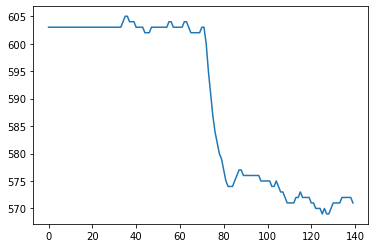

In [3]:
# prior_min= [0.0004, 0.0004, 0.09, 9e-7, 9e-7, 9e-7, 145, 148, 95, 50, 0.949, 4]
# prior_mmax = [0.0006, 0.0006, 2.5, 1.1e-6, 1.1e-6, 1.1e-6, 185, 105, 105, 80, 0.96, 7]

# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 150, 50, 100, 50, 0.96, 5]))
# test_theta = torch.from_numpy(np.array([0.0188, 0.05, 2.4, 2.6, 0.0000001, 0.0000001, 100, 50, 4]))
# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 5, 5, 1, 3]))
# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 1, 1, 1]))
# test_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.05, 0.0000001, 0.0000001, 155, 155, 0.5, 0.5, 0.5, 1.009]))
# test_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.05, 0.0000001, 0.0000001, 155, 155, 0.5, 0.5, 0.5, 1.009, 5500]))
test_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.05, 0.0000001, 0.0000001, 155, 155, 0.5, 0.5, 0.5, 1.009, 1.009,1.009, 5500]))


simulated_test = FACTS(test_theta)
x_time = np.linspace(0,500, num=140)
# plt.plot(x_time, simulated_test)
plt.plot(simulated_test)

Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77


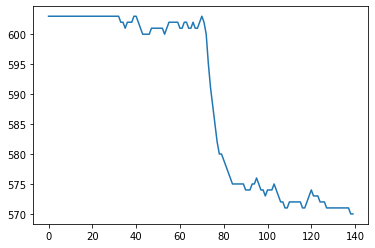

In [4]:
simulated_test = FACTS(test_theta)
x_time = np.linspace(0,500, num=140)
plt.plot(simulated_test)

In [5]:
print(test_theta.shape)

torch.Size([15])


### Run an example trial, or do a parameter sweep

#### 0 Auditory noise scale:

Low: 0.0001

High: 0.04


#### 1 Somatosensory noise scale:

Low: .002

High: 1


#### 2 TSE Process Scale:

Low: 0.0001

High: 5


#### 3 TSE Covariance Scale:

Low: 0.0000001

High: 5

#### 4 ASE Process Scale:

Low: 10e-12

High: 10e-6


#### 5 ASE Covariance Scale:

Low: 10e-12

High: 10e-4


#### 6 SensoryDelay Auditory Delay:

Low: 20

High: 105

#### x7 SensoryDelay Somato Delay:

Low: 45

High: 105

#### x8 TSE estimated_auditory_delay:

Low: 10 

High: 105

#### x9 ASE estimated_somat_delay

Low: 10 

High: 30

#### 10 cc_discount


### Load Parell's data to see what it looks like

In [6]:
# import observed data
data = scipy.io.loadmat('sbi_resources/parrell_2017/parrell_data.mat')

In [7]:
print(data['parrell_data'].dtype)
print(data['parrell_data']['means'][0,0][0,0][0].shape)
print(data['parrell_data']['stds'][0,0][0,0][0].shape)

[('means', 'O'), ('stds', 'O')]
(1, 171)
(1, 171)


### Print some of these data to see what it looks like

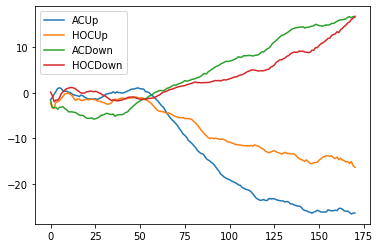

In [8]:
items = ['ACUp', 'HOCUp', 'ACDown', 'HOCDown']

for item in items:
    #pdb.set_trace()
    this_mean = data['parrell_data']['means'][0,0][item][0,0]
    if "Up" in item:
        this_mean = this_mean * -1
    plt.plot(this_mean.T, label=item)
    
plt.legend()

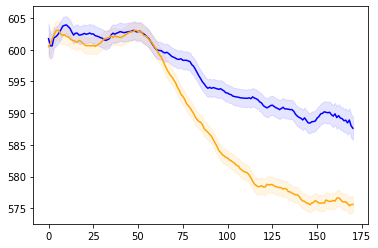

In [9]:
items = ['HOCUp', 'ACUp',]
offset = 603
# offset = 530

# for item in items:
#     #pdb.set_trace()
#     this_mean = data['parrell_data']['means'][0,0][item][0,0]
#     if "Up" in item:
#         this_mean = this_mean * -1 + offset
#     plt.plot(this_mean.T, label=item)
    
# plt.legend()

healthy_mean = data['parrell_data']['means'][0,0]['HOCUp'][0,0][0,:] *-1 +offset +1
cereb_mean = data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:] *-1 +offset -1

plt.plot(healthy_mean, color='blue', label='HC')
plt.plot(cereb_mean, color='orange', label='CD')

cereb_ci = np.abs( data['parrell_data']['stds'][0,0]['ACUp'][0,0][0,:] )
healthy_ci = np.abs(data['parrell_data']['stds'][0,0]['HOCUp'][0,0][0,:] )

plt.fill_between(range(len(cereb_mean)), (cereb_mean-cereb_ci), (cereb_mean+cereb_ci), color='orange', alpha=.1)
plt.fill_between(range(len(healthy_mean)), (healthy_mean-healthy_ci), (healthy_mean+healthy_ci), color='b', alpha=.1)


In [ ]:
# print(data['parrell_data']['stds'][0,0]['ACUp'])

# print(data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:])

# # print(cereb_ci)
# print(data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:]  ==  data['parrell_data']['stds'][0,0]['ACUp'][0,0][0,:] )
# plt.plot(cereb_ci)

## Test if original theta leads to paper results

In [ ]:
# x_time = np.linspace(-200,300, num=150)
# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
# formant_test = FACTS(original_theta)
# plt.plot(x_time, formant_test)

In [ ]:
# print(np.min(trial_cells_mat[729,:]))
# print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

## Run Simulations and/or Load data

In [ ]:
# original_theta

In [ ]:

# import facts_for_SBI

load_instead = False

#Auditory noise scale:
# Low: 0.0001
# High: 0.04
#Somatosensory noise scale:
# Low: .002
# High: 1
#TSE Process Scale:
# Low: 0.0001
# High: 5
#TSE Covariance Scale:
# Low: 0.0000001
# High: 5
#ASE Process Scale:
# Low: 10e-12
# High: 10e-6
#ASE Covariance Scale:
# Low: 10e-12
# High: 10e-4
#SensoryDelay Auditory Delay:
# Low: 20
# High: 105
#SensoryDelay Somato Delay:
# Low: 45
# High: 105
#CC_reduction_from_delay
# Low: 20
# High: 60

# import your simulator, define your prior over the parameters
#prior_mean = 0.002

# prior_min= [0.00001, 0.00002, 0.00001, 1e-8, 1e-8, 1e-8, 75, 75, 90, 30, 0.95, 1.0]
# prior_mmax = [0.4, 1.0, 10.0, 1e-4,     1e-4, 1e-4,     163, 250, 250, 100, 0.96, 15]

# prior_min= [0.0001, 0.0001, 0.01, 1e-8, 1e-8, 1e-8, 140, 90, 90, 40, 0.95, 4.0]
# prior_mmax = [0.01, 0.001, 6.0, 1e-5, 1e-5, 1e-5, 200, 110, 110, 80, 0.96, 8.0]

# prior_min= [0.0001, 0.0001, 0.09, 1e-7, 1e-7, 1e-7, 145, 90, 90, 70, 0.95, 5]
# prior_mmax = [0.001, 0.001, 0.2, 1e-6, 1e-6, 1e-6, 155, 110, 110, 80, 0.96, 7]

# prior_min= [0.0004, 0.0004, 0.09, 9e-7, 9e-7, 9e-7, 145, 148, 95, 50, 0.949, 4]
# prior_mmax = [0.0006, 0.0006, 2.5, 1.1e-6, 1.1e-6, 1.1e-6, 185, 105, 105, 80, 0.96, 7]

# prior_min= [  0.004, 0.004, .001,  .001,  9e-7,     9e-7, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
# prior_mmax = [0.006, 0.006,  2.5,  .05, 1.1e-6,   1.1e-6, 180, 180,         1,     1,      1,  1.040,  1.040,    1.040,  1e6]

prior_min= [  0.001, 0.01,  .1,   .01,   9e-8,     9e-8, 150, 150,       100,   1e-17,      1,      1,      1,       1,    25]
prior_mmax = [ 0.01,  0.1,  2.5,  .05, 1.1e-5,   1.1e-5, 180, 180,      5000,       5,      10,  1.040,  1.040,    1.2,   1000]

# prior_min= [    0.0,   0.0, 1e-8,  1e-8,  9e-8,     9e-8, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
# prior_mmax = [  1e-4, 1e-4,    1,    1, 1.1e-5,   1.1e-5, 180, 180,     1e10,   1e10,   1e10,      3,      3,       3,   1e6]

num_sim = 50
num_workers = 1

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')
    
# prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
for jj in range(0,100):
    print(jj)
    if load_instead == False:    
        try:
            theta, x = simulate_for_sbi(simulator2, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
            #parameter_posterior = infer(simulator2, prior, method='SNPE', num_simulations=num_sim, num_workers=num_workers)
#             density_estimator = inference.append_simulations(theta, x).train()
#             posterior = inference.build_posterior(density_estimator)

        # Save the theta and x
            with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}_local{jj}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([theta, x], f)
        # Save the posterior
#         with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}_local6.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#             pickle.dump([posterior], f)
        except Exception as e:
            print(e)
    
# else:


Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 124
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
0


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 108
compensati

Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 113 84
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_on 114 85
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 87
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 134 105
compensation_adapt

compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 105
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 89
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 90
Warning |ASE val

compensation_adaptive_frame_off 97 66
compensation_adaptive_frame_on 98 67
compensation_adaptive_frame_off 100 69
compensation_adaptive_frame_on 101 70
Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 103 72
compensation_adaptive_frame_on 104 73
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 117 83
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 118 84
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 120 86
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_on 121 87
Warning |ASE value| g

compensation_adaptive_frame_off 123 94
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_on 124 95
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE va

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_ad

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 53
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE val

compensation_adaptive_frame_off 127 93
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 94
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 130 96
compensation_adaptive_frame_on 131 97
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond

Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 97
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
compensation_adaptive_frame_off 109 80
compensation_adaptive_frame_on 110 81
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_

Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 137
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensati

compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 117 86
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 118 87
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptiv

Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 68
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_on 70 41
Warning |ASE val

compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 108
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE valu

compensation_adaptive_frame_off 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 109
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 121 87
compensation_adaptive_frame_on 122 88
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 124 90
Warning |ASE va

Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 78
compensation_adaptive_frame_off 107 78
compensation_adaptive_frame_on 108 79
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive

Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 86
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 121 89
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
Warning |ASE value| greater than 3, results are beyond 

Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 114 83
compensation_adaptive_frame_on 115 84
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 117 86
Warning |ASE 

Warning |ASE value| greater than 3, results are beyond training data regime 70
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |A

compensation_adaptive_frame_off 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 89
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 90
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 122 92
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 93
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 125 95
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_on 126 96
Warning |ASE value| greater than 3, results are beyo

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 131
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyon

compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value|

Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value|

Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 69 37
compensation_adaptive_frame_off 71 39
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 114 81
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 82
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 117 84
Warning |ASE val

Warning |ASE value| greater than 3, results are beyond training data regime 124
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 95
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 96
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 101
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 136 102
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 104
compensati

Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
Warning |ASE value| greater than 3, results are beyond training data regime 79
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_

Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 99
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 102
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 105
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensat

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE val

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
Warning |ASE value| greater than 3, results are beyond training data regime 43
Warning |ASE value| greater than 3, results are beyond training data regime 56
Warning |ASE value| greater than 3, results are beyond training data regime 61
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 77 45
compensation_adaptive_frame_on 78 46
Warning |ASE value|

Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 84
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 85
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 87
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 88
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 122 90
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 91
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 125 93
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_on 126 94
Warning |ASE value| greater than 3, results are beyo

Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 123 90
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_on 124 91
Warning |ASE value| greater than 3, results are beyond training data regime 125
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 93
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 132 99
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 100
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
Warning |ASE value| greater than 3, results are beyo

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 43
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
compensation_adaptive_frame_off 110 80
compensation_adaptive_frame_on 111 81
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 113 83
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_on 114 84
Warning |ASE value| greater than 3, results are beyond tr

compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_off 129 98
compensation_adaptive

Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 90
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 130 101
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value

compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 120 87
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_on 121 88
compensation_adaptive_frame_off 123 90
compensation_adaptive_frame_on 124 91
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| gre

compensation_adaptive_frame_off 135 101
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 136 102
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 104
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
Warning |ASE value| 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 113 84
compensation_ad

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 94
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 95
Warning |A

compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensa

Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 82
compensation_adaptive_frame_off 90 60
compensation_adaptive_frame_on 91 61
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 97
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
compensation_adaptive_frame_off 112 82
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 129 99
compensation_adaptive_

Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 124 91
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 127 94
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 95
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
compensation_adaptive_frame_off 139 106
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 119 87
compensation_adap

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 109 79
compensation_adaptive_frame_on 110 80
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 112 82
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
compensation_adaptive_

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
Warning |ASE value| greater than 3, results are beyond training data regime 130
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 98
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 99
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 134 101
Warning |ASE value| greater than 3, results are bey

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 85
compensation_adaptive_frame_on 119 86
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 121 88
Warning |ASE value| greater than 3, results are beyond t

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 111 81
compensation_adaptive_frame_on 112 82
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_off 116 86
compensation_adaptive_frame_on 117 87
compensation_adaptive_frame_off 119 89
compensation_adaptive_frame_on 120 90
compensation_adaptive_frame_off 122 92
compensation_adaptive_frame_on 123 93
compensation_adaptive_frame_off 125 95
compensation_adaptive_frame_on 126 96
compensation_adaptive

Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE va

Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 79 48
compensation_adaptive_frame_on 80 49
Warning |ASE value| greater than 3, results are beyond training data regime 81
compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
Warning |ASE value| greate

Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 42
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
Warning |ASE value| greater than 3, results are beyond training data regime 77
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 82 50
compensation_adaptive_frame_on 83 51
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
Warning |ASE value| greater than

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 98
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 101
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensa

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 133 103
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 106
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 107
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE

Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 108
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning 

Warning |ASE value| greater than 3, results are beyond training data regime 77
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
c

Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 91
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 127 93
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 94
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 130 96
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 97
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 102
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 103
Warning |AS

Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 110 79
compensation_adaptive_frame_on 111 80
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 113 82
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_on 114 83
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 85
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 86
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 88
Warning |A

Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 82
compensation_adaptive_frame_off 90 56
compensation_adaptive_frame_on 91 57
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_off 116 82
compensation_adaptive_frame_on 117 83
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 85
Warning |ASE value| greater than 3, results are beyond 

Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
Warning |ASE value| greater than 3, results are beyond training data regime 42
Warning |ASE value| greater than 3, results are beyond training data regime 43
Warning |ASE value| greater than 3, results are beyond training data regime 55
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE v

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
Warning |ASE value| greater than 3, results are beyond training data

Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results a

Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 130
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 101
Warning |ASE value| greater than 3, results 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 100 68
compensation_adaptive_frame_on 101 69
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 

compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE 

compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE 

Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 124 93
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 102
compensation_

compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 123 92
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_on 124 93
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 96
compensation_adaptive_frame_off 129 98
compensation_adaptive_frame_on 130 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
Warning |ASE value| greater than 3, results are beyond

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond traini

compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 38 7
compensation_adaptive_frame_off 40 9
compensation_adaptive_frame_on 41 10
compensation_adaptive_frame_off 43 12
compensation_adaptive_frame_on 45 14
compensation_adaptive_frame_off 47 16
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_fram

Warning |ASE value| greater than 3, results are beyond training data regime 105
compensation_adaptive_frame_off 108 78
Warning |ASE value| greater than 3, results are beyond training data regime 109
compensation_adaptive_frame_on 109 79
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 131 101
compensation_adaptive_frame_on 132 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 105
compensation_adaptive_frame_off 137 107
Warning |ASE value| greater than 3, results are beyond training data regime 138
compe

Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 73 41
Warning |A

compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE valu

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 106 77
compensation_adaptive_frame_on 107 78
Warning |ASE value| greater than 3, results are beyond training data regime 109
compensation_adaptive_frame_off 109 80
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_on 110 81
Warning |ASE value| 

Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are be

Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 106 76
compensation_adaptive_frame_on 107 77
Warning |ASE value| greater than 3, results are beyond training data regime 109
compensation_adaptive_frame_off 109 79
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_on 110 80
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 112 82
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_on 113 83
compensation_adaptive_frame_off 115 85
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_on 116 86
compensation_adaptive_frame_off 118 88
compensation_ada

Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 127 94
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 95
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 130 97
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 98
compensation_adaptive_frame_off 133 100
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 101
compensation_adaptive_frame_off 136 103
compensation_adaptive_frame_on 137 104
Warning |ASE value| greater than 3, results are bey

Warning |ASE value| greater than 3, results are beyond training data regime 124
Warning |ASE value| greater than 3, results are beyond training data regime 132
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 121 88
compensation_adaptive_frame_on 122 89
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 124 91
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 53
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 79 45
compensation_adaptive_frame_on 80 46
Warning |ASE value| greater than 3, results are beyond training data regime 81
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
Warning |ASE value| greater 

compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compens

compensation_adaptive_frame_off 111 81
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_on 112 82
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 85
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 118 88
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 120 90
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_on 121 91
Warning |ASE value| greater than 3, results are beyo

compensation_adaptive_frame_off 84 53
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_on 85 54
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 87 56
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_on 88 57
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_off 90 59
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_on 91 60
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_off 93 62
Warning |ASE value| greater than 3, results are beyond training data regime 94
compensation_adaptive_frame_on 94 63
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 77 44
compensation_adaptive_frame_on 78 45
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63


Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 120 88
compensation_adaptive_frame_on 121 89
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 123 91
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_on 124 92
compensation_adaptive_frame_off 126 94
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 95
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 97
compensation_

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 101
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond

compensation_adaptive_frame_off 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 110
Warnin

compensation_adaptive_frame_off 135 105
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 136 106
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 108
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 48 15
compensation_adaptive_frame_off 50 17
compensation_adaptive_frame_on 51 18
compensation_adaptive_frame_off 53 20
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond t

compensation_adaptive_frame_on 133 103
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond tr

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 124 95
compensation_adaptive_frame_on 125 96
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond trai

Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 112 79
compensation_adaptive_frame_on 113 80
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_off 115 82
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_on 116 83
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 85
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 86
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 121 88
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_on 122 89
compensation_adaptive_frame_off 124 91
Warning |ASE v

compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 35 3
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_off 36 4
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_fra

Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 102
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 103
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 105
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 136 106
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 108
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 70 41
Warning |

compensation_adaptive_frame_off 121 92
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_on 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 124 95
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 96
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 104
Warning |A

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 131
Warning |ASE value| greater than 3, results are beyond training data regime 132
Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 137
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warnin

compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_a

Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond

Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 75 41
Warning |ASE value| gr

compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
Warning |ASE value| greater than 3, results are beyond training data regime 105
compensation_adaptive_frame_off 106 73
compensation_adaptive_frame_on 107 74
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 117 84
compensation_adaptive_frame_on 118 85
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 132 99
compensation_adaptive_frame_on 133 100
compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 72 43
compensation_adaptive_fram

compensation_adaptive_frame_off 135 102
compensation_adaptive_frame_on 136 103
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 105
compensation_adaptive_frame_on 139 106
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value|

compensation_adaptive_frame_on 67 36
compensation_adaptive_frame_off 69 38
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 57
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_off 92 62
compensation_adaptive_frame_on 93 63
Warning |ASE value| greater than 3, results are beyond training d

compensation_adaptive_frame_off 125 93
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 128 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 105
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are be

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 89
Warning |ASE value| greater than 3, results are beyond tr

compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 125 95
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_on 126 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 98
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value

Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |A

compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 88 59
Warning |ASE value| greater than 3, results are beyond training data regime

Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 123 92
compensation_adaptive_frame_on 124 93
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensati

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| 

compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
compensation_adaptive_frame_off 90 61
compensation_adaptive_frame_on 91 62
compensation_adaptive_frame_off 93 64
compensation_adaptive_frame_on 94 65
compensation_adaptive_frame_off 96 67
Warning |ASE value| greater than 3, results are beyond training data regime 97
compensation_adaptive_frame_on 97 68
Warning |ASE value| greater than 3, results are beyond training data regime 98
compensation_adaptive_frame_off 99 70
compensation_adaptive_frame_on 100 71
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 115 86
compensation_adaptive_frame_on 116 87
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data 

compensation_adaptive_frame_off 123 94
compensation_adaptive_frame_on 124 95
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 97
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 98
compensation_adaptive_frame_off 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE va

Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 45
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 93
Warning |ASE 

Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 87
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 88
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 90
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 91
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are b

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value|

compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame

compensation_adaptive_frame_on 132 99
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 104
compensation_adaptive_frame_on 138 105
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE va

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
Warning |ASE value| greater than 3, results are beyond training data regime 77
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 83 51
compensation_adaptive_frame_on 84 52
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_off 86 54
compensation_adaptive_frame_on 87 55
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
Warning |ASE value| greater than 3, results

24


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| 

compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
Warning |ASE value| greater than 3, results are beyond training data regime 101
compensation_adaptive_frame_off 103 71
compensation_adaptive_frame_on 104 72
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond trainin

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 75 41
Warning |ASE value| grea

compensation_adaptive_frame_off 126 94
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 95
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 97
compensation_adaptive_frame_on 130 98
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
25


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_off 106 77
Warning |ASE value| greater than 3, results are beyond training data regime 107
compensation_adaptive_frame_on 107 78
Warning |ASE value| greater than 3, results are beyond training data regime 109
compensation_adaptive_frame_off 109 80
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_on 110 81
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 112 83
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_on 113 84
Warning |ASE 

compensation_adaptive_frame_off 83 50
compensation_adaptive_frame_on 84 51
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_off 86 53
compensation_adaptive_frame_on 87 54
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 89 56
compensation_adaptive_frame_on 90 57
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 96 63
compensation_adaptive_frame_on 97 64
Warning |ASE value| greater than 3, results are beyond training data regime 98
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 104 71
compensation_adaptive_frame_on 105 72
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 

Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 94
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 105
Warning |ASE value| greater than 3, results are 

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 36 4
compensation_adaptive_frame_off 38 6
compensation_adaptive_frame_on 39 7
compensation_adaptive_frame_off 43 11
compensation_adaptive_frame_on 53 21
compensation_adaptive_frame_off 55 23
compensation_adaptive_frame_on 56 24
compensation_adaptive_frame_off 58 26
compensation_adaptive_frame_on 62 30
compensation_adaptive_frame_off 64 32
compensation_adaptive_frame_on 70 38
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, result

compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
compensation_adaptive_frame_off 97 67
compensation_adaptive_frame_on 98 68
compensation_adaptive_frame_off 101 71
compensation_adaptive_frame_on 102 72
26


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 36 3
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_off 38 5
compensation_adaptive_frame_on 40 7
compensation_adaptive_frame_off 42 9
compensation_adaptive_frame_on 57 24
Warning |ASE value| greater than 3, results are beyond training data regime 58
compensation_adaptive_frame_off 61 28
compensation_adaptive_frame_on 70 37
compensation_adaptive_frame_off 72 39
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regim

Warning |ASE value| greater than 3, results are beyond training data regime 102
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_off 118 86
compensation_adaptive_frame_on 119 87
compensation_adaptive_frame_off 121 89
compensation_adaptive_frame_on 122 90
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
compensation_adaptive_frame_off 127 95
compensation_adaptive_frame_on 128 96
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
compensation_adaptive_frame_off 133 101
compensation_adaptive_frame_on 134 102
compensation_adaptive_frame_off 136 104
compensation_adaptive_frame_on 137 105
compensation_adaptive_frame_off 139 107
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
compensation_adaptive_frame_off 81 50
compensation_adaptive_frame_on 82 51
compensation_adaptive_frame_off 84 53
compensation_adaptive_frame_on 85 54
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 88 57
compensation_adaptive_frame_on 89 58
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 9

Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 39 8
compensation_adaptive_frame_off 41 10
Warning |ASE value| greater than 3, results are beyond training data regime 46
compensation_adaptive_frame_on 61 30
compensation_adaptive_frame_off 63 32
compensation_adaptive_frame_on 68 37
Warning |ASE value| greater than 3, results are beyond training data regime 69
compensation_adaptive_frame_off 70 39
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 93
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 111
compensation_adaptive_frame_off 126 93
compensation_adaptive_frame_on 127 94
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 96
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 97
Warning |ASE value| greater than 3, results are beyond training data regime 131
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 132 99
Warning |ASE value| greater than 3, results are bey

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 124
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_a

compensation_adaptive_frame_on 74 44
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 80 50
compensation_adaptive_frame_on 81 51
compensation_adaptive_frame_off 83 53
compensation_adaptive_frame_on 84 54
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 94 64
compensation_adaptive_frame_on 95 65
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 135 105
compensation_adaptive_frame_on 136 106
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 71 41
compensation_adaptive_frame_off 75 45
compensation_adaptive_frame_on 76 46
compensation_adaptive_frame_off 84 54
compensation_adaptive_frame_on 85 55
compensation_adaptive_frame_off 114 84
compensation_adaptive_frame_on 115 85
compensation_adaptive_frame_off 121 91
com

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 126 97
compensation_adaptive_frame_on 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 134 105
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 131 102
compensation_ad

Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 127 93
compensation_adaptive_frame_on 128 94
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_

compensation_adaptive_frame_off 127 98
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 102
compensation_adaptive_frame_off 133 104
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_on 73 41
Warning |ASE va

compensation_adaptive_frame_on 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond t

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 42
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
Warning |ASE value|

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| grea

Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 100
compensation_adaptive_frame_on 130 101
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 108 74
compensati

Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 93
compensation_adaptive_frame_off 129 95
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value|

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
Warning |ASE value| greater than 3, results are beyond training data regime 77
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
Warning |ASE value| greater than 3, res

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 109
compensation_adaptive_frame_off 111 80
compensation_adaptive_frame_on 112 81
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 114 83
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 84
Warning |ASE val

Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
Warning |ASE value| greater than 3, results are beyond training data regime 78
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
Warning |ASE value| greater than 3, results are beyond training data regime 81
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
Warning |ASE value| greater than 3, results are beyond training data regime 84
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
Warning |ASE value| greater than 3, results are beyond training data regime 9

compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
compensation_adaptive_frame_off 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| g

Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are bey

Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 74 43
compensation_adaptive_frame_on 75 44
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 78 47
compensation_adaptive_frame_on 79 48
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 91 60
compensation_adaptive_frame_on 92 61
Warning |ASE value| greater than 3, results are beyond training data regime 93
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
Warning |ASE value| greater than 3, res

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 136 102
compensation_adaptive_frame_on 137 103
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 79
compensation_adaptive_frame_off 89 57
compensation_adaptive_frame_on 90 58
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
Warning |ASE value| greater than 3, results are beyond trainin

Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 93
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 70 41
Warning |ASE

compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 37 6
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_off 39 8
compensation_adaptive_frame_on 42 11
compensation_adaptive_frame_off 46 15
compensation_adaptive_frame_on 51 20
compensation_adaptive_frame_off 53 22
compensation_adaptive_frame_on 56 25
compensation_adaptive_frame_off 60 29
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 47
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3,

compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_off 80 46
compensation_adaptive_frame_on 81 47
compensation_adaptive_frame_off 84 50
compensation_adaptive_frame_on 85 51
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
compensation_adaptive_frame_off 99 65
compensation_adaptive_frame_on 100 66
compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 125 91
compensation_adaptive_frame_on 126 92
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 

compensation_adaptive_frame_off 104 70
compensation_adaptive_frame_on 105 71
Warning |ASE value| greater than 3, results are beyond training data regime 106
compensation_adaptive_frame_off 109 75
compensation_adaptive_frame_on 110 76
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE va

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 72 41
32


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 111 79
compensation_adaptive_frame_on 112 80
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 114 82
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 83
compensation_ada

compensation_adaptive_frame_on 124 91
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 93
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 94
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 96
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 97
Warning |ASE value| greater than 3, results are beyond training data regime 131
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 132 99
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 100
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 102
Warning |ASE value| greater than 3, results are be

compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
Warning |ASE value| greater than 3, results are beyond training data regime 84
compensation_adaptive_frame_off 85 54
compensation_adaptive_frame_on 86 55
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
Warning |ASE value| greater than 3, results are beyond training data regime 94
compensation_adaptive_frame_off 99 68
compensation_adaptive_frame_on 100 69
Warning |ASE value| greater than 3, results are beyond training data regime 101
compensation_adaptive_frame_off 102 71
compensation_adaptive_frame_on 103 72
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 104
compensation_adaptive_frame_o

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 125
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training d

33


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 42
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 124 91
compensation_adaptive_frame_on 125 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive

compensation_adaptive_frame_off 82 51
compensation_adaptive_frame_on 83 52
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 92 61
compensation_adaptive_frame_on 93 62
compensation_adaptive_frame_off 95 64
compensation_adaptive_frame_on 96 65
compensation_adaptive_frame_off 98 67
compensation_adaptive_frame_on 99 68
compensation_adaptive_frame_off 101 70
compensation_adaptive_frame_on 102 71
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 3

Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 108
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 113 84
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensa

Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 108
compensation_adaptive_frame_on 139 109
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 121 89
compensation_ad

compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 107
compensation_adaptive_frame_on 137 108
compensation_adaptive_frame_off 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyon

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 41 7
compensation_adaptive_frame_off 46 12
compensation_adaptive_frame_on 52 18
compensation_adaptive_frame_off 54 20
compensation_adaptive_frame_on 55 21
compensation_adaptive_frame_off 58 24
compensation_adaptive_frame_on 59 25
compensation_adaptive_frame_off 61 27
compensation_adaptive_frame_on 66 32
compensation_adaptive_frame_off 70 36
compensation_adaptive_frame_on 74 40
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36

compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 89
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 90
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 122 92
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 93
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 125 95
Warning |ASE 

Warning |ASE value| greater than 3, results are beyond training data regime 95
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results a

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
compensation_adaptive_frame_off 101 69
compensation_adaptive_frame_on 102 70
compensation_adaptive_frame_off 104 72
compensation_adaptive_frame_on 105 73
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensati

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_off 73 43
compensation_adaptive_frame_on 74 44
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 76 46
compensation_adaptive_frame_on 77 47
compensation_adaptive_frame_off 79 49
compensation_adaptive_frame_on 80 50
Warning |ASE value| greater than 3, results are beyond training data regime 81
compensation_adaptive_frame_off 82 52
compensation_adaptive_frame_on 83 53
compensation_adaptive_frame_off 85 55
compensation_adaptive_frame_on 86 56
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 88 58
compensation_adaptive_frame_on 89 59
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 91 61
compensation_adaptive_frame_on 92 62
Warning |ASE value| greater than 3, results

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 115 81
compensation_adaptive_frame_on 116 82
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_

Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 99
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 134 101
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 102
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 137 104
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 105
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are 

compensation_adaptive_frame_off 132 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 102
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
compensation_adaptive_frame_off 138 107
compensation_adaptive_frame_on 139 108
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value|

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond trainin

compensation_adaptive_frame_on 136 103
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 105
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 139 106
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 137 103
Warning 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond traini

Warning |ASE value| greater than 3, results are beyond training data regime 48
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 98
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_

Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 116 84
compensation_adaptive_frame_on 117 85
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 87
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training da

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 105
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 88
compensation_adaptive_frame_on 119 89
compensation_adaptive_frame_off 121 91
compensation_adaptive_frame_on 122 92
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
Warning |ASE value

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| 

Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 42
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
Warning |AS

Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 43
Warning |ASE value| greater than 3, results are beyond training data regime 60
compensation_adaptive_frame_on 72 41
Warning |ASE val

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 57
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 96
compensation_adaptive_frame_off 114 85
compensation_adaptive_frame_on 115 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 94
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_ada

Warning |ASE value| greater than 3, results are beyond training data regime 78
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
Warning |ASE value| greater than 3, results are beyond training data regime 81
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 91 58
compensation_adaptive_frame_on 92 59
Warning |ASE value| greater than 3, results are beyond training data regime 93
compensation_adaptive_frame_off 95 62
compensation_adaptive_frame_on 96 63
Warning |ASE value| greater than 3, results are beyond training data regime 97
compensation_adaptive_frame_off 98 65
compensation_adaptive_frame_on 99 66
compensation_adaptive_frame_off 101 68
compensation_adaptive_frame_on 102 69
com

Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 113 81
compensation_adaptive_frame_on 114 82
compensation_adaptive_frame_off 116 84
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 85
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
compensation_adaptive_frame_off 122 90
compensation_adaptive_frame_on 123 91
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
compensation_adaptive_frame_off 134 102
compensation_adaptive

Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 101
compensation_adaptive_frame_off 132 103
compensation_adaptive_frame_on 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_adaptive_frame_on 73 41
Warning |AS

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 44
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 119 86
compensation_adaptive_frame_on 120 87
Warning |ASE value| g

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 72 43
compensation_adaptive_frame_on 73 44
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 75 46
compensation_adaptive_frame_on 76 47
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_off 87 58
compensation_adaptive_frame_on 88 59
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_off 90 61
c

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 89
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value

Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE val

Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 125
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 134
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are b

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensatio

compensation_adaptive_frame_off 133 104
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 110
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |A

Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_off 115 83
compensation_adaptive_frame_on 116 84
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 86
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 87
Warning |ASE value| greater than 3, results are bey

compensation_adaptive_frame_off 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 105
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 109
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 134
compen

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond traini

compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 107
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 121 90
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_on 122 91
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptiv

Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 130 97
compensation_adaptive_frame_on 131 98
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 133 100
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 101
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 103
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 104
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |

Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 123 91
compensation_adaptive_frame_on 124 92
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 130 98
compensation_adaptive_frame_on 131 99
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 101
compensat

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 107
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 113
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 97
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation

compensation_adaptive_frame_off 116 83
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 84
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 86
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 87
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 122 89
compensation_adaptive_frame_on 123 90
compensation_adaptive_frame_off 125 92
compensation_adaptive_frame_on 126 93
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
compensation_adaptive_frame_off 131 98
compensation_adaptive_frame_on 132 99
compensation_adaptive_frame_off 134 101
compensation_adaptive_frame_on 135 102
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 104
compensation_adapti

compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 119
Warning |ASE value| greater than 3, results are beyond training data regime 132
Warning |ASE value| greater than 3, results are beyond training data regime 135
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| g

Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 106
compensation_adaptive_frame_on 136 107
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_

Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond train

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adapt

compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 91
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond trai

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value|

compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 88 54
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_on 89 55
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 91 57
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_on 92 58
Warning |ASE value| greater than 3, results are beyond training data regime 93
compensation_adaptive_frame_off 94 60
Warning |ASE value| greater than 3, results are beyond training data regime 95
compensation_adaptive_frame_on 95 61
Warning |ASE value| greater than 3, results are beyond training data regime 96
compensation_adaptive_frame_off 97 63
Warning |ASE value| greater than 3, results are beyond training data regime 98
compensation_adaptive_frame_on

compensation_adaptive_frame_on 119 90
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 121 92
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_on 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 124 95
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 96
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 127 98
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 99
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 101
Warning |ASE value| greater than 3, results are bey

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 125
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 106
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_off 139 109
compensation_adaptive_frame_on 71 41
Warning |

Warning |ASE value| greater than 3, results are beyond training data regime 45
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 78 47
compensation_adaptive

Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 79
Warning |ASE value| 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 100
compensation_adaptive_frame_off 112 81
compensation_adaptive_frame_on 113 82
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_off 115 84
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_on 116 85
compensation_adaptive_frame_off 118 87
compensation_adaptive_frame_on 119 88
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 121 90
compensation_adaptive_frame_on 122 91
Warning |ASE value|

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 106
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 134
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 111
compensation_adaptive_frame_off 121 92
compensation_adaptive_frame_on 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_ada

Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 117
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 99
compensation_adaptive_frame_off 132 101
compensation_adaptive_frame_on 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 104
compensation_adaptive_frame_on 136 105
Warning |ASE v

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 111
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 94
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 125 96
Warning |ASE val

compensation_adaptive_frame_off 122 93
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 94
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
Warning |ASE value| greater than 3, results are bey

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 74 45
compensation_adaptive_frame_on 75 46
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 77 48
compensation_adaptive_frame_on 78 49
compensation_adaptive_frame_off 80 51
compensation_adaptive_frame_on 81 52
compensation_adaptive_frame_off 83 54
compensation_adaptive_frame_on 84 55
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_off 86 57
compensation_adaptive_frame_on 87 58
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 95 66
compensation_adaptive_frame_on 96 67
Warning |ASE value| greater than 3, results are

Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 80
Warning |ASE value| greater than 3, results are beyond training data regime 85
Warning |ASE value| greater than 3, results are beyond training data regime 95
Warning |ASE value| greater than 3, results are beyond training data regime 112
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond t

Warning |ASE value| greater than 3, results are beyond training data regime 123
47


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 103
Warning |ASE value| greater than 3, results are beyond training data regime 104
compensation_adaptive_frame_off 113 83
compensation_adaptive_frame_on 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_off 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_on 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_off 119 89
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_on 120 90
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_a

Warning |ASE value| greater than 3, results are beyond training data regime 112
compensation_adaptive_frame_off 133 99
compensation_adaptive_frame_on 134 100
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 102
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 103
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_off 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
compensation_adaptive_frame_off 79 47
compensation_adaptive_frame_on 80 48
Warning |ASE value| greater than 3, results are beyond training data regime 95
compensation_adaptive_frame_off 98 66
compensation_adaptive

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
compensation_adaptive_frame_off 138 109
compensation_adaptive_frame_on 139 110
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 95
compensation_adaptive_frame_off 134 100
compensation_adaptive_frame_on 135 101
Warning |ASE value| greater than 3, results are beyond trainin

Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 94
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_on 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_off 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensat

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 111
compensation_adaptive_frame_off 115 81
Warning |ASE value| greater than 3, results are beyond training data regime 116
compensation_adaptive_frame_on 116 82
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 84
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 85
Warning |ASE va

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 133 103
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_on 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 136 106
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_on 137 107
compensation_adaptive_frame_off 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
compensation_adaptive_frame_on 75 41
Warning |ASE 

Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 89
Warning |ASE value| greater than 3, results are beyond training data regime 90
Warning |ASE value| greater than 3, results are beyond training data regime 99
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 111
compensation_adaptive_frame_off 111 80
compensa

Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 120 89
compensation_adaptive_frame_on 121 90
Warning |ASE value| greater than 3, results are beyond training data regime 123
Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_off 124 93
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 94
Warning |ASE value| greater than 3, results are beyond training data regime 126
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 130 99
compensati

Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are bey

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 64
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 81
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 97
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond t

compensation_adaptive_frame_on 77 44
Warning |ASE value| greater than 3, results are beyond training data regime 78
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
Warning |ASE value| greater than 3, results are beyond training data regime 89
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_off 93 60
compensation_adaptive_frame_on 94 61
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
Warning |ASE value| greater than 3, resul

Warning |ASE value| greater than 3, results are beyond training data regime 108
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 114 82
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 83
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 117 85
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 118 86
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 120 88
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_on 121 89
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 123 91
Warning |A

Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 77
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 96
Warning |ASE value| greater than 3, results are beyond training data regime 97
Warning |ASE value| greater than 3, results are beyond tr

compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 86
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 58
compensation_adaptive_frame_on 61 28
compensation_adaptive_fr

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 44
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
50


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond trainin

Warning |ASE value| greater than 3, results are beyond training data regime 41
Warning |ASE value| greater than 3, results are beyond training data regime 54
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 114
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| gre

Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 100
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 102
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 103
compensation_adaptive_frame_off 134 105
compensation_adaptive_frame_on 135 106
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 108
compensation_adaptive_frame_on 138 109
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 37 3
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_off 39 5
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE v

Warning |ASE value| greater than 3, results are beyond training data regime 124
compensation_adaptive_frame_on 124 93
Warning |ASE value| greater than 3, results are beyond training data regime 125
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 99
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 132 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_on 133 102
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensat

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
compensation_adaptive_frame_off 124 93
compensation_adaptive_frame_on 125 94
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_on 128 97
compensation_adaptive_frame_off 130 99
compensation_adaptive_frame_on 131 100
compensation_adaptive_frame_off 133 102
compensation_adaptive_frame_on 134 103
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
compensation_adaptive_frame_off 139 108
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| 

Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 123 89
compensation_adaptive_frame_on 124 90
Warning |ASE value| greater than 3, results are beyond training data regime 126
compensation_adaptive_frame_off 126 92
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_on 127 93
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 129 95
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_on 130 96
compensation_adaptive_frame_off 132 98
Warning |ASE value| 

compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
compensation_adaptive_frame_off 137 106
compensation_adaptive_frame_on 138 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 34 5
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_off 36 7
compensation_adaptive_frame_on 41 12
compensation_adaptive_frame_off 45 16
compensation_adaptive_frame_on 46 17
compensation_adaptive_frame_o

compensation_adaptive_frame_off 128 97
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_on 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 100
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 101
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 103
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 106
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results ar

compensation_adaptive_frame_off 116 85
compensation_adaptive_frame_on 117 86
compensation_adaptive_frame_off 119 88
compensation_adaptive_frame_on 120 89
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_off 122 91
compensation_adaptive_frame_on 123 92
compensation_adaptive_frame_off 125 94
compensation_adaptive_frame_on 126 95
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 128 97
compensation_adaptive_frame_on 129 98
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 131 100
compensation_adaptive_frame_on 132 101
compensation_adaptive_frame_off 134 103
compensation_adaptive_frame_on 135 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| g

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_off 92 60
compensation_adaptive_frame_on 93 61
Warning |ASE value| greater than 3, results are beyond training data regime 94
compensation_adaptive_frame_off 98 66
compensation_adaptive_frame_on 99 67
Warning |ASE value| greater than 3, results are beyond training data regime 137
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater

compensation_adaptive_frame_off 89 58
compensation_adaptive_frame_on 90 59
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 136 105
compensation_adaptive_frame_on 137 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 128 95
compensation_adaptive_frame_on 129 96
Warning |ASE value| greater than 3, results are beyond training data regime 131
compensation_adaptive_frame_off 131 98
Warning |ASE value| greater than 3, results are beyond training data regime 132
compensation_adaptive_frame_on 132 99
Warning |ASE value| 

compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_off 124 92
compensation_adaptive_frame_on 125 93
Warning |ASE value| greater than 3, results are beyond training data regime 127
Warning |ASE value| greater than 3, results are beyond training data regime 128
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
Warning |ASE value| greater than 3, results are beyond training data regime 130
compensation_adaptive_frame_off 132 100
compensation_adaptive_frame_on 133 101
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 103
compensation_adaptive_frame_on 136 104
compensation_adaptive_frame_off 138 106
compensation_adaptive_frame_on 139 107
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE v

compensation_adaptive_frame_off 83 52
compensation_adaptive_frame_on 84 53
Warning |ASE value| greater than 3, results are beyond training data regime 85
compensation_adaptive_frame_off 86 55
compensation_adaptive_frame_on 87 56
Warning |ASE value| greater than 3, results are beyond training data regime 88
compensation_adaptive_frame_off 89 58
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_on 90 59
Warning |ASE value| greater than 3, results are beyond training data regime 91
compensation_adaptive_frame_off 96 65
compensation_adaptive_frame_on 97 66
Warning |ASE value| greater than 3, results are beyond training data regime 98
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regi

Warning |ASE value| greater than 3, results are beyond training data regime 103
compensation_adaptive_frame_off 114 84
Warning |ASE value| greater than 3, results are beyond training data regime 115
compensation_adaptive_frame_on 115 85
Warning |ASE value| greater than 3, results are beyond training data regime 116
Warning |ASE value| greater than 3, results are beyond training data regime 117
compensation_adaptive_frame_off 117 87
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_on 118 88
Warning |ASE value| greater than 3, results are beyond training data regime 120
compensation_adaptive_frame_off 120 90
Warning |ASE value| greater than 3, results are beyond training data regime 121
compensation_adaptive_frame_on 121 91
compensation_adaptive_frame_off 123 93
compensation_adaptive_frame_on 124 94
compensation_adaptive_frame_off 126 96
compensation_adaptive_frame_on 127 97
compensation_adaptive_frame_off 129 99
compensation_ada

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 57
Warning |ASE value| greater than 3, results are beyond training data regime 66
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
compensation_adaptive_frame_off 81 48
compensation_adaptive_frame_on 82 49
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 84 51
compensation_adaptive_frame_on 85 52
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 87 54
compensation_adaptive_frame_on 88 55
compensation_adaptive_frame_off 90 57
compensation_adaptive_frame_on 91 58
Warning |ASE value| greater than 3,

Warning |ASE value| greater than 3, results are beyond training data regime 110
compensation_adaptive_frame_off 119 87
compensation_adaptive_frame_on 120 88
Warning |ASE value| greater than 3, results are beyond training data regime 122
compensation_adaptive_frame_off 122 90
Warning |ASE value| greater than 3, results are beyond training data regime 123
compensation_adaptive_frame_on 123 91
compensation_adaptive_frame_off 125 93
compensation_adaptive_frame_on 126 94
compensation_adaptive_frame_off 128 96
compensation_adaptive_frame_on 129 97
compensation_adaptive_frame_off 131 99
compensation_adaptive_frame_on 132 100
Warning |ASE value| greater than 3, results are beyond training data regime 133
compensation_adaptive_frame_off 134 102
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_off 137 105
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond t

Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 126 95
compensation_adaptive_frame_on 127 96
Warning |ASE value| greater than 3, results are beyond training data regime 129
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 108
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 84
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 97
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond

compensation_adaptive_frame_off 132 98
compensation_adaptive_frame_on 133 99
Warning |ASE value| greater than 3, results are beyond training data regime 134
compensation_adaptive_frame_off 135 101
compensation_adaptive_frame_on 136 102
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 104
compensation_adaptive_frame_on 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 33
Warning |ASE value| greater than 3, results are beyond training data regime 34
Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_a

Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_off 126 92
compensation_adaptive_frame_on 127 93
Warning |ASE value| greater than 3, results are beyond training data regime 128
Warning |ASE value| greater than 3, results are beyond training data regime 130
Warning |ASE value| greater than 3, results are beyond training data regime 138
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_off 139 105
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
Warning |ASE value| greater than 3, results are beyond training data regime 104
Warning |ASE 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 93
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
Warning |ASE value| greater than 3, results are beyond training data regime 41
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| 

compensation_adaptive_frame_off 104 75
compensation_adaptive_frame_on 105 76
compensation_adaptive_frame_off 107 78
Warning |ASE value| greater than 3, results are beyond training data regime 108
compensation_adaptive_frame_on 108 79
compensation_adaptive_frame_off 111 82
compensation_adaptive_frame_on 112 83
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
Warning |ASE value| greater than 3, results are beyond training data regime 127
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 131 102
compensation_adaptive_frame_on 132 103
Warning |ASE value| greater than 3, results are beyond training 

compensation_adaptive_frame_off 134 102
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_on 135 103
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 137 105
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_on 138 106
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyon

Warning |ASE value| greater than 3, results are beyond training data regime 111
Warning |ASE value| greater than 3, results are beyond training data regime 120
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 76 43
compensation_adaptive_frame_on 77 44
Warning |ASE value| greater than 3, results are beyond training data regime 78
compensation_adaptive_frame_off 79 46
compensation_adaptive_frame_on 80 47
compensation_adaptive_frame_off 82 49
compensation_adaptive_frame_on 83 50
compensation_adaptive_frame_off 85 52
compensation_adaptive_frame_on 86 53
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
compensation_adaptive_frame_off 92 59
compensation_adaptive_frame_on 93 60
compensation_adaptive_frame_off 97 6

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

compensation_adaptive_frame_on 54 20
compensation_adaptive_frame_off 56 22
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
compensation_adaptive_frame_on 71 41
Warning |ASE value| greater than 3, results are beyond training data regime 72
compensation_adaptive_frame_off 115 85
compensation_adaptive_frame_on 116 86
Warning |ASE value| greater than 3, results are beyond training data regime 118
compensation_adaptive_frame_off 118 88
Warning |ASE value| greater than 3, results are beyond training data regime 119
compensation_adaptive_frame_on 119 89
Warning |ASE value| great

compensation_adaptive_frame_on 122 92
compensation_adaptive_frame_off 124 94
compensation_adaptive_frame_on 125 95
compensation_adaptive_frame_off 127 97
compensation_adaptive_frame_on 128 98
Warning |ASE value| greater than 3, results are beyond training data regime 129
compensation_adaptive_frame_off 130 100
compensation_adaptive_frame_on 131 101
compensation_adaptive_frame_off 133 103
compensation_adaptive_frame_on 134 104
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 136 106
compensation_adaptive_frame_on 137 107
Warning |ASE value| greater than 3, results are beyond training data regime 138
compensation_adaptive_frame_off 139 109
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE valu

compensation_adaptive_frame_on 86 53
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 88 55
compensation_adaptive_frame_on 89 56
Warning |ASE value| greater than 3, results are beyond training data regime 90
compensation_adaptive_frame_off 91 58
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_on 92 59
compensation_adaptive_frame_off 94 61
compensation_adaptive_frame_on 95 62
Warning |ASE value| greater than 3, results are beyond training data regime 96
compensation_adaptive_frame_off 97 64
compensation_adaptive_frame_on 98 65
Warning |ASE value| greater than 3, results are beyond training data regime 99
compensation_adaptive_frame_off 100 67
compensation_adaptive_frame_on 101 68
compensation_adaptive_frame_off 103 70
compensation_adaptive_frame_on 104 71
Warning |ASE value| greater than 3, results are beyond training data regime 105
compensation_adaptive_frame_off 10

Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 137 103
compensation_adaptive_frame_on 138 104
Warning |ASE value| greater than 3, results are beyond training data regime 139
Warning |ASE value| greater than 3, results are beyond training data regime 32
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
compensation_adaptive_frame_off 73 44
compensation_adaptive_frame_on 74 45
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_off 78 49
compensation_adaptive_frame_on 79 50
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 81 52
compensation_adaptive_frame_on 82 53
Warning |ASE value| greater than 3, results are beyond training data regime 83
compensation_adaptive_frame_off 84 55
compensation_adaptive_frame_on 85 56
compensation_adaptive_frame_o

Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 49
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 33
compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 78
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 83
Warning |ASE value| greater than 3, results are beyond training data regime 101
Warning |ASE value| greater than 3, results are beyond training data regime 102
Warning |ASE value| greater than 3, results are beyond 

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 35
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
compensation_adaptive_frame_off 75 43
compensation_adaptive_frame_on 76 44
Warning |ASE value| greater than 3, results are beyond training data regime 77
compensation_adaptive_frame_off 78 46
compensation_adaptive_frame_on 79 47
Warning |ASE value| greater than 3, results are beyond training data regime 80
compensation_adaptive_frame_off 81 49
compensation_adaptive_frame_on 82 50
compensation_adaptive_frame_off 84 52
compensation_adaptive_frame_on 85 53
compensation_adaptive_frame_off 88 56
compensation_adaptive_frame_on 89 57
compensation_adaptive_frame_off 91 59
compensation_adaptive_frame_on 92 60
Warning |ASE value| greater than 3, results are beyond training data regime 93
compensation_adaptive_frame_off 94 62
compensation_adaptive_frame_on 95 63
Warning |ASE value| greater than 3, results

compensation_adaptive_frame_on 85 53
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensation_adaptive_frame_off 87 55
compensation_adaptive_frame_on 88 56
compensation_adaptive_frame_off 90 58
compensation_adaptive_frame_on 91 59
Warning |ASE value| greater than 3, results are beyond training data regime 92
compensation_adaptive_frame_off 93 61
compensation_adaptive_frame_on 94 62
Warning |ASE value| greater than 3, results are beyond training data regime 95
compensation_adaptive_frame_off 96 64
compensation_adaptive_frame_on 97 65
compensation_adaptive_frame_off 99 67
compensation_adaptive_frame_on 100 68
Warning |ASE value| greater than 3, results are beyond training data regime 101
compensation_adaptive_frame_off 102 70
compensation_adaptive_frame_on 103 71
Warning |ASE value| greater than 3, results are beyond training data regime 104
compensation_adaptive_frame_off 105 73
compensation_adaptive_frame_on 106 74
Warning |ASE value| greater than 3, 

Warning |ASE value| greater than 3, results are beyond training data regime 35
compensation_adaptive_frame_on 72 41
Warning |ASE value| greater than 3, results are beyond training data regime 73
Warning |ASE value| greater than 3, results are beyond training data regime 36
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 109
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 115
Warning |ASE value| greater than 3, results are beyond training data regime 121
Warning |ASE value| greater than 3, results are beyond training data regime 122
Warning |ASE value| greater than 3, results are beyo

Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 74 41
Warning |ASE value| greater than 3, results are beyond training data regime 75
compensation_adaptive_frame_on 35 3
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_off 37 5
compensation_adaptive_frame_on 62 30
compensation_adaptive_frame_off 65 33
compensation_adaptive_frame_on 69 37
compensation_adaptive_frame_off 71 39
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 82
Warning |ASE value| greater than 3, results are beyond training data regime 37
compensation_adaptive_frame_on 74 41
compensation_adaptive_frame_off 124 91
Warning |ASE value| greater than 3, results are beyond training data regime 125
compensation_adaptive_frame_on 125 92
compensation_adaptive_frame_off 129 96
compensation_adaptive_frame_on 130 97
compensation_adaptive_frame_off 136 1

compensation_adaptive_frame_off 89 60
compensation_adaptive_frame_on 90 61
compensation_adaptive_frame_off 92 63
compensation_adaptive_frame_on 93 64
compensation_adaptive_frame_off 98 69
compensation_adaptive_frame_on 99 70
Warning |ASE value| greater than 3, results are beyond training data regime 32
Warning |ASE value| greater than 3, results are beyond training data regime 34
compensation_adaptive_frame_on 70 41
compensation_adaptive_frame_off 110 81
compensation_adaptive_frame_on 111 82
compensation_adaptive_frame_off 113 84
compensation_adaptive_frame_on 114 85
compensation_adaptive_frame_off 116 87
compensation_adaptive_frame_on 117 88
compensation_adaptive_frame_off 119 90
compensation_adaptive_frame_on 120 91
compensation_adaptive_frame_off 122 93
compensation_adaptive_frame_on 123 94
compensation_adaptive_frame_off 125 96
compensation_adaptive_frame_on 126 97
compensation_adaptive_frame_off 128 99
compensation_adaptive_frame_on 129 100
compensation_adaptive_frame_off 132 103


Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 50
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
compensation_adaptive_frame_off 77 43
compensation_adaptive_frame_on 78 44
compensation_adaptive_frame_off 82 48
compensation_adaptive_frame_on 83 49
compensation_adaptive_frame_off 85 51
compensation_adaptive_frame_on 86 52
Warning |ASE value| greater than 3, results are beyond training data regime 87
compensation_adaptive_frame_off 88 54
compensation_adaptive_frame_on 89 55
compensation_adaptive_frame_off 91 57
compensation_adaptive_frame_on 92 58
Warning |ASE value| greater than 3, results are beyond training data regime 93
compensation_adaptive_frame_off 94 60
compensation_adaptive_frame_on 95 61
compensation_adaptive_frame_off 97 63
c

Warning |ASE value| greater than 3, results are beyond training data regime 134
Warning |ASE value| greater than 3, results are beyond training data regime 135
compensation_adaptive_frame_off 135 104
Warning |ASE value| greater than 3, results are beyond training data regime 136
compensation_adaptive_frame_on 136 105
Warning |ASE value| greater than 3, results are beyond training data regime 137
compensation_adaptive_frame_off 138 107
Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 139 108
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
Warning |ASE value| greater than 3, results are beyond training data regime 64
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 86
compensati

compensation_adaptive_frame_on 70 41
Warning |ASE value| greater than 3, results are beyond training data regime 71
Warning |ASE value| greater than 3, results are beyond training data regime 36
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 114
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 39
Warning |ASE value| greater than 3, results are beyond training data regime 40
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are beyond training data regime 76
Warning |ASE value| greater than 3, results are beyond training data regime 88
Warning |ASE value| greater than 3, results are beyond training data regime 94
Warning |ASE value| greater than 3, results are beyond training data regime 118
Warning |ASE value

Warning |ASE value| greater than 3, results are beyond training data regime 139
compensation_adaptive_frame_on 73 41
Warning |ASE value| greater than 3, results are beyond training data regime 74
Warning |ASE value| greater than 3, results are beyond training data regime 87
Warning |ASE value| greater than 3, results are beyond training data regime 92
Warning |ASE value| greater than 3, results are beyond training data regime 100
Warning |ASE value| greater than 3, results are beyond training data regime 105
Warning |ASE value| greater than 3, results are beyond training data regime 110
Warning |ASE value| greater than 3, results are beyond training data regime 113
Warning |ASE value| greater than 3, results are beyond training data regime 133
Warning |ASE value| greater than 3, results are beyond training data regime 37
Warning |ASE value| greater than 3, results are beyond training data regime 38
compensation_adaptive_frame_on 75 41
Warning |ASE value| greater than 3, results are bey

## Load theta and x

In [ ]:
# Get list of all pickle files matching string
all_files = os.listdir('./sbi_resources')
selected_files = [x for x in all_files if 'theta_x_' in x]
# selected_files = [x for x in all_files if 'theta_x_' in x and 'local' in x]


# Iterate through list
all_theta, all_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
for file_string in selected_files:
    file = open(f'./sbi_resources/{file_string}', 'rb')
#     pdb.set_trace()
    this_theta, this_x = pickle.load(file)

    # Append 
    all_theta = torch.cat((all_theta, this_theta))
    all_x = torch.cat((all_x, this_x))

    # Close file
    file.close()    
print(all_theta.shape)
print(all_x.shape)




In [ ]:
# Add data stored from multi-inference
# Aggregate the training data
# all_files = os.listdir('./sbi-logs/multiSNPE')
# selected_files_theta = [x for x in all_files if 'theta' in x ]
# selected_files_x = [x for x in all_files if 'x' in x]


# # Iterate through list
# all_multi_theta, all_multi_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
# for i, file_string in enumerate(selected_files_x):
# #     file = open(f'./sbi-logs/multiSNPE/{file_string}', 'rb')
#     this_multi_theta = torch.load(f'./sbi-logs/multiSNPE/{selected_files_theta[i]}')
#     this_multi_x = torch.load(f'./sbi-logs/multiSNPE/{selected_files_x[i]}')

#     # Append 
#     all_multi_theta = torch.cat((all_multi_theta, this_multi_theta))
#     all_multi_x = torch.cat((all_multi_x, this_multi_x))
  


# all_theta = torch.cat((all_theta, all_multi_theta))
# all_x = torch.cat((all_x, all_multi_x))

# print(all_theta.shape)
# print(all_x.shape)

In [ ]:
# labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
#           'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
#           'Auditory Delay', 'Somato Delay', 'AUKF_Qmult_for_pert', 
#           'AUKF_Rmult_for_pert', 'AUKF_Pmult_for_pert', 'AUKF_learning_rate']


print(labels[-6])
filter_some_data=True
if filter_some_data == True:
    filter_bool = all_theta[:,-6] < 180
    all_x = all_x[filter_bool]
    all_theta = all_theta[filter_bool]
    
print('after too large Auditory Delay filter')
print(all_theta.shape)
print(all_x.shape)

# filter_data_on_magnitude=True
# if filter_data_on_magnitude == True:
#     filter_bool = torch.any(all_x < 498, dim=1)
#     all_x = all_x[~filter_bool]
#     all_theta = all_theta[~filter_bool]
    
print('after magnitude filter')
print(all_theta.shape)
print(all_x.shape)

In [ ]:
filter_some_data=True
if filter_some_data == True:
    filter_bool2 = (all_x != -1).all(axis=1)
    all_x = all_x[filter_bool2]
    all_theta = all_theta[filter_bool2]
  
print('after negative filter')
print(all_theta.shape)
print(all_x.shape)

In [ ]:
## Apply closest 250 filter
# print('before closest data shape')
# print(all_theta.shape)
# print(all_x.shape)
# n=25
# filter_closest_samples = True
# if filter_closest_samples == True:
#     all_x_ds = torch.cat( (all_x_ds[indicesHC[0:n],:], all_x_ds[indices[0:n],:]) )
#     all_theta = torch.cat( (all_theta[indicesHC[0:n],:], all_theta[indices[0:n],:]) )
  
# print('after filter')
# print(all_theta.shape)
# print(all_x_ds.shape)

#### Get density and posterior estimations

### Resample cereb data so that it resamples to 5ms to match FACTS

In [ ]:
from scipy.interpolate import interp1d
###Downsample data to match simulator output 
def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

cereb_mean_ds = downsample(cereb_mean, 100)
healthy_mean_ds = downsample(healthy_mean, 100)

cereb_ci_ds = downsample(cereb_ci, 100)
healthy_ci_ds = downsample(healthy_ci, 100)

print(cereb_mean_ds.shape)

### Create simulated data of preonset

The first 40 frames appear to have the same unperturbed data

In [ ]:
def create_precompensation_synthetic_data(orig_data):
#     precomp_mean = np.mean(orig_data[0:40])
#     precomp_std = np.std(orig_data[0:40])
#     precomp_offset = 530
    precomp_offset = 603

    cereb_synth = np.array([precomp_offset]*40)
    return np.concatenate( (cereb_synth, orig_data) )


cereb_mean_synth = create_precompensation_synthetic_data(cereb_mean_ds)
healthy_mean_synth = create_precompensation_synthetic_data(healthy_mean_ds)
#pdb.set_trace()
x_time = np.arange(-200,500,5)
plt.plot(x_time, cereb_mean_synth )
plt.title('Cereb')
#plt.ylim([500, 535])
plt.xlim([-200,500])

plt.figure()
plt.plot(x_time, healthy_mean_synth )
plt.title('HC')
#plt.ylim([500, 535])
print(healthy_mean_synth.shape)
plt.xlim([-200,500])



### Only grab the first 140 samples to match Ben's data

100 FACTS samples covers 0-500ms

40 FACTS samples covers 200ms preperturbation, which we wont plot

In [ ]:
all_x_ds = all_x[:,0:140]
print(all_x_ds.shape)
print(all_theta.shape)
# print(all_x_ds)
# print(all_theta)

In [ ]:
# Print some of the training data, just to make sure it is diverse
sample_size = all_x_ds.shape[0]
n = sample_size
x_time = np.linspace(-200,700, num=140)
x_time_repeated = np.tile(x_time, n).reshape(n, -1)


random_samples_indices = np.random.choice(sample_size, n, replace=False)

plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T)
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )
plt.plot(simulated_test, '*',label='FACTS')

plt.legend()

In [ ]:
# Show the closest training samples
differencesHC = abs(all_x_ds - healthy_mean_synth)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 5
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

# Plot which lines are closest
differences = abs(all_x_ds - cereb_mean_synth)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

# Sort by sum
differences_FACTS = abs(all_x_ds - simulated_test)
differencesFACTS_summed = torch.sum(differences_FACTS, dim=1)
sorted_tensorF, indicesF = torch.sort(differencesFACTS_summed)

plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesF[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(simulated_test, '*', color='green', label='FACTS' )
plt.title(f'Closest {n} training ')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

In [ ]:
# What if we smooth the cereb_mean_synth and the healthy_mean_synth?

def smooth_np_convolve(data, window_size = 3):
    # Get a pad
    # Pad the data at the edges
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')

    # Define the sliding average window size
    kernel = np.ones(window_size) / window_size

    # Apply the sliding average
    smoothed_data_interior = np.convolve(padded_data, kernel, mode='valid')

    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]
    smoothed_data[-1] = data[-1]
    smoothed_data[1:-1] = smoothed_data_interior[1:-1]
    return smoothed_data

smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
# plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )

plt.plot(smoothed_healthy)
plt.plot(smoothed_cereb)
print(healthy_mean_synth.shape)
print(smoothed_healthy.shape)

In [ ]:
# Show the closest training samples
differencesHC = abs(all_x_ds - smoothed_healthy)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 5
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
plt.plot(smoothed_healthy.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

plt.ylim([570, 605])
# plt.ylim([490, 540])

# Plot which lines are closest
differences = abs(all_x_ds - smoothed_cereb)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(smoothed_cereb.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)
plt.ylim([570, 605])
# plt.ylim([490, 540])

#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T, label='_nolegend_', alpha=0.3)
h1 = plt.plot(smoothed_healthy.reshape(1,140).T, '*', markersize=5, label= 'HC data')
h2 = plt.plot(smoothed_cereb.reshape(1,140).T, '*', markersize=5, label='CD data' )
h3 = plt.plot(all_x_ds[0,:].T, label='Simulation data', alpha=0.1)
plt.title('Comparing simulation training data to human empirical data')
plt.xlabel('Frame')
plt.ylabel('Formant (Hz)')
plt.legend()

In [ ]:
# Plot without empiri
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Differences in HC vs CD F1 Compensation')

In [ ]:


# Plot without empiri
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))

ft_size = 26

plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


# plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
# plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)', fontsize=ft_size,)
plt.ylabel('F1 Response (Hz)', fontsize=ft_size)

plt.legend(fontsize=ft_size)
plt.title('HC F1 Compensation', fontsize=ft_size)


font = {'family' : 'normal',
        'weight' : 'normal',
        }
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.8)
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.ylim([570,606])
# plt.ylim([490,540])



plt.figure(figsize=(12,8))
# plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Healthy Controls')
# plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Cerebellar Degeneration')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)', fontsize=ft_size,)
plt.ylabel('F1 Response (Hz)', fontsize=ft_size,)

plt.legend(fontsize=ft_size)
plt.title('CD F1 Compensation', fontsize=ft_size,)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.9)
plt.ylim([570,606])
# plt.ylim([490,540])

In [ ]:
# prior_min= [  0.004, 0.004, .001,  .001,  9e-7,     9e-7, 150, 150,    1,  1,  1,  1.000]
# prior_mmax = [0.006, 0.006,  2.5,  .05, 1.1e-6,  1.1e-6, 180, 180,     3,  3,   3, 1.020]
# prior_min= [  1e-10, 1e-10, 1e-10,  1e-10,  1e-10,     1e-10, 100, 100,    1e-10,  1e-10,  1e-10,  1.000, 25]
# prior_mmax = [10,       10,    10,     10,     10,        10, 280, 280,     5,  5,   5, 10, 1e6]

prior_min= [  0.0001, 0.0001, .0001,  .001,  9e-8,     9e-8, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
prior_mmax = [  0.1,   0.1,  2.5,  .05, 1.1e-5,   1.1e-5, 180, 180,         1,     1,      1,  1.040,  1.040,    1.040,  1e6]

# prior_min= [    0.0,   0.0, 1e-8,  1e-8,  9e-8,     9e-8, 150, 150,    1e-10,  1e-10,  1e-10,      1,      1,       1,    25]
# prior_mmax = [  1e-4, 1e-4,    1,    1, 1.1e-5,   1.1e-5, 180, 180,     1e10,   1e10,   1e10,      3,      3,       3,   1e6]

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')

run_and_save = True
print(len(prior_min))
# Downsample all_x
if run_and_save:
    density_estimator = inference.append_simulations(all_theta, all_x_ds).train(force_first_round_loss=True,
                                                                                discard_prior_samples=True, 
                                                                                show_train_summary=True,
                                                                               training_batch_size=32,
                                                                                learning_rate = 5e-5,
                                                                               ) # Look more into force_first_round_loss=True
#     density_estimator = inference.append_simulations(all_theta[0:100000,:], all_x_ds[0:100000]).train(force_first_round_loss=True)
#     posterior = inference.build_posterior(density_estimator, sample_with='mcmc')
    posterior = inference.build_posterior(density_estimator)

    # Save the posterior
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_local_nsf.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([posterior], f)
        
else:
#     with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_72000_local.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_767179_okay.pkl', 'rb') as f:  # Python 3: open(..., 'wb')

#         pdb.set_trace()
        object_file = pickle.load(f)
        posterior = object_file[0]

In [ ]:
# # Save the posterior
print(all_theta.size()[0])
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posterior], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)


In [ ]:
# Helper function
def get_modes(data):
    # Initialize list to store modes
    modes = []
    
    # Iterate over each dimension (column) in the data
    for i in range(data.shape[1]):
        kde = stats.gaussian_kde(data[:, i])
        x = np.linspace(data[:, i].min(), data[:, i].max(), 1000)
        mode_x = x[np.argmax(kde.evaluate(x))]
        modes.append(mode_x)
    
    return np.array(modes)

In [ ]:
# labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
#           'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
#           'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE','cc_discount_from_delay_ASE', 
#           'cc_decay', 'cc_minimum']
labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
          'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
          'Auditory Delay', 'Somato Delay', 
          'AUKF_Rmult_for_pert', 
          'AUKF_Qmult_for_pert', 
          'AUKF_Pmult_for_pert', 
          'AUKF_learning_rate_R',
         'AUKF_learning_rate_Q',
         'AUKF_learning_rate_P',
         'sensory_error_threshold']

## Sample the posterior for the mean of all trials

In [ ]:
sample_size = 1000
# sample_size = all_theta.size()[0]

In [ ]:
samples_test_FACTS = posterior.sample((sample_size,), x=simulated_test)
# samples_test_FACTS = posterior.sample((702438,), x=simulated_test)

In [ ]:
# samples_cereb = posterior.sample((all_theta.size()[0],), x=cereb_mean_synth)
samples_cereb = posterior.sample((sample_size,), x=cereb_mean_synth)
# samples_cereb = posterior.sample((sample_size,), x=smoothed_cereb)

In [ ]:
# samples_healthy = posterior.sample((all_theta.size()[0],), x=healthy_mean_synth)
samples_healthy = posterior.sample((sample_size,), x=healthy_mean_synth)
# samples_healthy = posterior.sample((sample_size,), x=smoothed_healthy)

In [ ]:
# plt.rcParams.update({'font.size': 16})
# plt.xticks(rotation=70)
# out = pairplot(samples, figsize=(26,15), upper='kde', diag='kde', labels=labels, set_xticks['rotation']=45)

In [ ]:
# print(out[1][0][0])
# got_ticks = out[1][0][0].get_xticks()
# out[1][0][0].set_xticks(got_ticks, rotation=45)

In [ ]:
# samples_cereb[1::10].size()

In [ ]:
# from itertools import cycle

# data = sns.load_dataset('iris')
# display(data)

# g = sns.PairGrid(data, hue='species')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# # pg.map_upper(plt.scatter)

In [ ]:
# display(px)
# print(samples_test_FACTS.shape)

In [ ]:
# plt.rcParams.update({'font.size': 12})

# #Append test_FACTS
px_testFACTS = pd.DataFrame(samples_test_FACTS).astype("float")
display(px_testFACTS)
px_testFACTS.set_axis(labels, axis="columns", inplace=True)
px_testFACTS["Group"] = "TestFACTS"

px2 = px_testFACTS
g = sns.PairGrid(px2, diag_sharey=False, corner=True)

# g = sns.pairplot(px, corner=True, kind='hist')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

In [ ]:

# display(HTML("<style>.container { width:100% !important; }</style>"))

# px_healthy = pd.DataFrame(samples_healthy[1::100]).astype("float")
# px_healthy.set_axis(labels, axis="columns", inplace=True)
# px_healthy["Group"] = "HC"

# g = sns.PairGrid(px_healthy, diag_sharey=False, corner=True, hue="Group", hue_order=['HC'])
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_healthy).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

#Append test_FACTS
# px_testFACTS = pd.DataFrame(samples_test_FACTS[1::2]).astype("float")
# px_testFACTS.set_axis(labels, axis="columns", inplace=True)
# px_testFACTS["Group"] = "TestFACTS"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

# g = sns.pairplot(px, corner=True, kind='hist')
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

In [ ]:
# import pandas as pd
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# px = pd.DataFrame(samples_healthy[1::10]).astype("float")
# px.set_axis(labels, axis="columns", inplace=True)
# g = sns.PairGrid(px, diag_sharey=False, corner=True)
# # g = sns.pairplot(px, corner=True, kind='hist')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)

### Test which parameters might need to be changed to get close to the observed data

In [ ]:
# torch.set_printoptions(sci_mode=False)

# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
# test_theta = torch.from_numpy(np.array([0.005, 0.005, .1, 2.0, 0.0000001, 0.0000001, 150, 50, 5]))
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# # pdb.set_trace()

# test_set = [50,100,120]

# for ii in range(5):
#     #pdb.set_trace()
# #     test_theta = original_theta.detach().clone()
# #     test_theta2[-1] = original_theta[-1]*2
#     manual_test = FACTS(test_theta)    
#     x_time = np.linspace(0,500, num=100)

#     plt.figure(figsize=(14,10))
#     plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_test[40:140], 'b',label=f'Original theta')
#     plt.plot(x_time, manual_test[40:140], 'red',label=f'Manual theta test')
# #     plt.axvline(x = 0, color = 'grey', ls=':')
#     plt.legend()

#     plt.xlabel('Time (ms)')
#     plt.ylabel('Formant response (Hz)')
#     plt.title('Healthy Empirical')

### Plot estimated formant to observed formant

In [ ]:
# from scipy import stats

# plt.rcParams.update({'font.size': 22})

# torch.set_printoptions(sci_mode=True)

posterior_modes_FACTS = stats.mode(samples_test_FACTS,0)
posterior_modes_FACTS = torch.from_numpy(posterior_modes_FACTS[0][0])
print(f'poster modes {posterior_modes_FACTS}')
# print(f'original theta {original_theta}')
# pdb.set_trace()

all_simulated_formant_facts = np.array([])
for ii in range(2):
    all_simulated_formant_facts = FACTS(posterior_modes_FACTS)
    if ii == 0:
        all_simulated_formant = all_simulated_formant_facts
    else:
        all_simulated_formant = np.vstack((all_simulated_formant, all_simulated_formant_facts))
        
#pdb.set_trace()
# simulated_formant = FACTS(posterior_modes_FACTS)
mean_formants = np.mean(all_simulated_formant, axis=0)
ci = np.std(all_simulated_formant, axis=0)

x_time = np.linspace(-200,700, num=140)

plt.figure(figsize=(14,10))
# Plot "Estimations"
plt.plot(x_time, mean_formants, label='estimated from posteriors')
plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='b', alpha=.1)

# Plot Empirical Data
plt.plot(x_time, simulated_test, 'k',label='FACTS output')
# plt.fill_between(x_time, (simulated_test-healthy_ci), (simulated_test+healthy_ci), color='k', alpha=.1)

#  plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('FACTS Empirical')

In [ ]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=30)

print(labels)
# posterior_modes_HC = stats.mode(samples_healthy,0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

posterior_modes_HC = get_modes(samples_healthy)
# posterior_modes_HC = np.average(samples_healthy, axis=0)
# posterior_modes_HC = np.median(samples_healthy, axis=0)
posterior_modes_HC = torch.from_numpy(posterior_modes_HC)
print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()


# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-2] = 0.98
# posterior_modes_HC_manual_test[2] = 0.04
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

# posterior_modes_HC_manual_test = torch.tensor([0.0005,
#             0.0005,
#             0.1,
#             0.000001, 
#             0.000001, 
#             0.000001,
#             150.0,
#             100.0,
#             100.0,
#             75.0,
#             0.958,
#             6.0]) 

# posterior_modes_HC2 = posterior_modes_HC.clone()
# posterior_modes_HC2[2] = posterior_modes_HC_manual_test[2]


for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)
#     print(f'posterior_modes_HC_manual_test {posterior_modes_HC_manual_test}')
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace() 
    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')

#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
    #     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')


In [ ]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)
np.set_printoptions(suppress=True)

best_HC_theta = all_theta[indicesHC[0],:]
print(best_HC_theta)
this_df_HC = pd.DataFrame({'Parameter label': labels,
#                         'posterior_modes_CD_manual_test': posterior_modes_HC_manual_test.numpy().tolist(),
                        'best_training_data':best_HC_theta.numpy().tolist(),
                       'posterior_modes_C': posterior_modes_HC.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_HC - best_HC_theta).numpy().tolist(),
                       'Percent diff': ((posterior_modes_HC - best_HC_theta)/best_HC_theta*100).numpy().tolist()
                       })

display(this_df_HC)


In [ ]:
print(labels)
# posterior_modes_C = stats.mode(samples_cereb,0)
# posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])

# posterior_modes_C = get_modes(samples_cereb)
# posterior_modes_C = np.median(samples_cereb, axis=0)
posterior_modes_C = np.average(samples_cereb, axis=0)
posterior_modes_C = torch.from_numpy(posterior_modes_C)
print(f'poster modes {posterior_modes_C}')
# print(posterior_modes.shape)
# pdb.set_trace()

#posterior_modes_C_manual_test = posterior_modes_C.detach().clone()
posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            150.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
posterior_modes_C2 = posterior_modes_C.clone()
posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_C = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
    
    x_time = np.linspace(0,500, num=100)

    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_C[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, all_simulated_formant_facts
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    #plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
#     plt.plot(x_time, simulated_formant_manual_test2[40:140], 'magenta',label='Manual test')
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
#     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
# print(f'% difference in parameter tensors {(posterior_modes_C - posterior_modes_CD_manual_test)/posterior_modes_CD_manual_test}')
print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta}')



In [ ]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)

# posterior_modes_C - best_theta)/best_theta
print(best_theta[0].tolist())
print((posterior_modes_C - best_theta[0]).numpy().tolist())
this_df = pd.DataFrame({'Parameter label': labels,
                        'best training data': best_theta[0].tolist(),
                       'posterior_modes_C': posterior_modes_C.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_C - best_theta[0]).numpy().tolist(),
                       'Percent diff': ((posterior_modes_C - best_theta[0])/best_theta[0]*100).numpy().tolist()
                       })

display(this_df)

In [ ]:
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')



# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='medium')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

In [ ]:
posterior_modes_C = stats.mode(samples_cereb,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])
print(f'poster modes {posterior_modes_C}')
# pdb.set_trace()

# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-1] = 8
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            180.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


all_simulated_formant_CD = np.array([])
for ii in range(2):
    simulated_formant = FACTS(posterior_modes_C)
    simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
#     pdb.set_trace()
    if ii == 0:
        all_simulated_formant_CD = simulated_formant
    else:
        all_simulated_formant_CD = np.vstack((all_simulated_formant_CD, simulated_formant))
    
    
# Plot data
x_time = np.linspace(0,500, num=100)

mean_formants_CD = np.mean(all_simulated_formant_CD, axis=0)[40:140]
plt.figure(figsize=(14,10))
plt.plot(x_time, mean_formants_CD, 'orange' ,label='Estimated from posteriors')
ci_CD = (1.96 * np.std(all_simulated_formant_CD,axis=0)/np.sqrt(all_simulated_formant_CD.shape[0]))[40:140]
plt.fill_between(x_time, (mean_formants_CD-ci_CD), (mean_formants_CD+ci_CD), color='orange', alpha=.1)

plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)

plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
#     plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('CD Empirical')



## Plot CD and HC in same plot

In [ ]:
# Plot Healthy Estimated
# plt.plot(x_time, mean_formants_HC, linestyle='--', label='Estimated from posteriors')
# ci_HC = (1.96 * np.std(all_simulated_formant_HC,axis=0)/np.sqrt(all_simulated_formant_HC.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_HC-ci_HC), (mean_formants_HC+ci_HC), color='b', alpha=.1)
# # Plot Healthy observed
# plt.plot(x_time, healthy_mean_synth[40:140], color='b',label='Mean of observed trials')
# plt.fill_between(x_time, (healthy_mean_synth[40:140]-cereb_ci_ds), (healthy_mean_synth[40:140]+cereb_ci_ds), color='b', alpha=.1)



# # Plot CD Estimated
# plt.plot(x_time, mean_formants_CD, 'orange', linestyle='--',label='Estimated from posteriors')
# ci_CD = (1.96 * np.std(all_simulated_formant_CD,axis=0)/np.sqrt(all_simulated_formant_CD.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_CD-ci_CD), (mean_formants_CD+ci_CD), color='orange', alpha=.1)
# # Plot CD observed
# plt.plot(x_time, cereb_mean_synth[40:140], 'orange', linestyle='-', label='Mean of observed trials')
# plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)



### Plot without truncating, just to see

In [ ]:
# posterior_modes_C = stats.mode(samples_cereb,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])
print(f'poster modes {posterior_modes_C}')
print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()

# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-1] = 8
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

all_simulated_formant = np.array([])
for ii in range(2):
    simulated_formant = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace()
    if ii == 0:
        all_simulated_formant = simulated_formant
    else:
        all_simulated_formant = np.vstack((all_simulated_formant, simulated_formant))
    
    
# # Plot data
x_time = np.linspace(-200,500, num=140)

mean_formants = np.mean(all_simulated_formant, axis=0)
plt.figure(figsize=(14,10))
plt.plot(x_time, mean_formants, 'orange' ,label='Estimated from posteriors')
ci = (1.96 * np.std(all_simulated_formant,axis=0)/np.sqrt(all_simulated_formant.shape[0]))
plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='orange', alpha=.1)

plt.plot(x_time, cereb_mean_synth, 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual test')
#     plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('CD Empirical')

## Now plot voilin plots

### Make a dataframe for easy violin plot

In [ ]:
# Iterate across labels and add these to the dataframe
# for ii in range(len(labels)):
#     this_column_name = labels[ii]
#     this_column_values_cereb = samples_cereb[ii,:]
#     this_column_values_HC = samples_healthy[ii,:]
    
#     this_column_lables_cereb = ["CD"] * len(this_column_values_cereb)
#     this_column_labels_HC =  ["HC"] * len(this_column_values_HC)

In [ ]:
# display(px4)
# print(np.mean(px4[px4['Group']=='CD']['value']))

In [ ]:
# Mann-Whitney U test
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import mannwhitneyu

# px3 = pd.melt(px_testFACTS, id_vars=['Group'])
# display(px3)

# print(posterior_modes_FACTS)
# for ii, label in enumerate(labels):
#     plt.figure()
#     px4 = px3[px3['variable']==label]
#     ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['TestFACTS'])
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     plt.ylabel('Parameter Value')
#     plt.xlabel('Parameter')
    
#     ax.hlines(y=original_theta[ii], xmin=-0.5, xmax=0.5, linewidth=2, color='r')
    
    # Calculate Non-parametric diff
#     CD_data = px4[px4['Group']=='CD']['value']
#     HC_data = px4[px4['Group']=='HC']['value']
#     stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
#     mean1 = np.mean(CD_data)
#     mean2 =  np.mean(HC_data)
#     std_hc = np.std(px4[px4['Group']=='HC']['value'])
#     glass_D = (mean1-mean2) / std_hc
    
#     plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}')

Interpret Glass effect size
https://www.uv.es/~friasnav/EffectSizeBecker.pdf

In [ ]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    
    
# plt.xticks(range(0,9), labels, rotation='vertical')
# plt.ylabel('Parameter Value')
# plt.xlabel('Parameter')

# Instead of Amortized, lets try Multi-round SNPE

# Multi-round on CD

In [ ]:
from sbi.inference import SNPE, simulate_for_sbi
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_CD_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]

In [ ]:
# torch.save(this_theta, 'sbi-logs/multiSNPE/theta1.pt')
# torch.save(this_x_r, 'sbi-logs/multiSNPE/x1.pt')

# test1 = torch.load('sbi-logs/multiSNPE/theta1.pt')
# test2 = torch.load('sbi-logs/multiSNPE/x1.pt')

# print(test1.shape)
# print(test2.shape)

In [ ]:
# If you get errors about Infs or NaNs: https://github.com/sbi-dev/sbi/issues/669
num_rounds = 10
num_sims = 55
posteriors_CD = []
x_o = torch.from_numpy(cereb_mean_synth)
# x_o = all_x_ds[indices[0:1],:]
proposal = posterior_CD_amort.set_default_x(x_o)

for _ in range(num_rounds):
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    # proposal2 = posterior.set_default_x(x_o)
    density_estimator_multi = inference.append_simulations(
        this_theta, this_x, proposal=proposal
    #     all_theta, all_x_ds, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=32, 
            discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_CD = inference.build_posterior(density_estimator_multi)
    posteriors_CD.append(posterior_multi_CD)
    proposal = posterior_CD_amort.set_default_x(x_o)

In [ ]:
# Save posteriors
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_{all_theta.size()[0]}_CD.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posteriors_CD], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_{all_theta.size()[0]}_CD.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)

In [ ]:
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_{all_theta.size()[0]}_CD.pkl')
print(obj)
posterior_CD_SNPE_loaded = obj[-1][-1]
# print(posterior_CD_SNPE_loaded[-1])

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_{all_theta.size()[0]}_CD.pkl')
print(obj)
inference_loaded = obj[-1]

In [ ]:
# posterior_multi_CD2 = inference_loaded.build_posterior(density_estimator_multi)

In [ ]:
# samples_cereb_multi = posterior.sample((sample_size,), x=smoothed_cereb)
# samples_cereb_multi = posteriors_CD[-1].sample((50,), x=smoothed_cereb)
# samples_cereb_multi = posterior_multi_CD2.sample((500,), x=cereb_mean_synth)
# samples_cereb_multi = posterior_CD_SNPE_loaded.sample((500,), x=cereb_mean_synth)

# posterior_modes_CD = stats.mode(samples_cereb_multi,0)
# posterior_modes_CD = torch.from_numpy(posterior_modes_CD[0][0])

posterior_modes_CD = get_modes(samples_cereb_multi)
# posterior_modes_CD = np.median(samples_cereb_multi, axis=0)
# posterior_modes_CD = np.average(samples_cereb_multi, axis=0)
posterior_modes_CD = torch.from_numpy(posterior_modes_CD)
print(f'poster modes {posterior_modes_CD}')

posterior_modes_CD_manual_test = all_theta[indices[0],:]#posterior_modes_CD.detach().clone()
# posterior_modes_CD_manual_test[-4] = all_theta[indices[0:1],-4]
# posterior_modes_CD_manual_test[3] = all_theta[indices[0:1],3]
# posterior_modes_CD_manual_test = torch.tensor([0.005,
#             0.0005,
#             4.0,
#             0.0000001, 
#             0.0001, 
#             0.000001,
#             150.0,
#             100.0,
#             100.8,
#             55.0,
#             0.955,
#             6.0])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
# posterior_modes_C2 = posterior_modes_CD.clone()
# posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

# best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_CD = FACTS(posterior_modes_CD)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
    
    x_time = np.linspace(0,500, num=100)

    
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_CD[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_formant_manual_test[40:140], label='simulated from best thetas')
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
print(f'Closest training data posteriors {all_theta[indices[0:1],:]}')
# print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta}')


In [ ]:
best_theta = all_theta[indices[0:1],:]
# print(f'Closest training data posteriors {best_theta}')
# print(f'Posterior parameter value {posterior_modes_CD}')
# print(f'% difference in parameter tensors {(posterior_modes_CD - best_theta)/best_theta}')

np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)

difference_parameter_tensors = (posterior_modes_CD - best_theta[0]).numpy()
percent_diff = ( difference_parameter_tensors/best_theta*100).numpy().flatten()

# print(f'difference_parameter_tensors {difference_parameter_tensors.tolist()} {len(difference_parameter_tensors.tolist())}')
# print(f'percent_diff {percent_diff} {len(percent_diff)}')
# print(f'posterior_modes_CD_manual_test {posterior_modes_CD_manual_test} {posterior_modes_CD_manual_test.numpy().tolist()}')
# print((posterior_modes_CD - best_theta[0]).numpy().tolist())
this_df = pd.DataFrame({'Parameter label': labels,
                        'prior_min': prior_min,
                        'best training data': best_theta[0].tolist(),
                       'posterior_modes_CD': posterior_modes_CD.numpy().tolist(),
                        'manual_test':posterior_modes_CD_manual_test.numpy().flatten().tolist(),
                        'prior_max': prior_mmax,
                       'difference in parameter tensors': difference_parameter_tensors.tolist(),
                       'Percent diff': percent_diff,
                       })

display(this_df)

In [ ]:
# for ii, diff in enumerate(percent_diff):
#     print(difference_parameter_tensors[ii])
#     print(diff)

In [ ]:
print(posterior_modes_CD)
print(best_theta[0])
print((posterior_modes_CD - best_theta[0])/best_theta*100)
print( ( (posterior_modes_CD - best_theta[0])/best_theta*100).numpy().flatten().tolist())
print( len( ( (posterior_modes_CD - best_theta[0])/best_theta*100).numpy().flatten().tolist())) 

# Plot posteriors vs closest training sample

In [ ]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'CD Posterior Dist vs Best training parameter')
    
    
# plt.xticks(range(0,9), labels, rotation='vertical')
# plt.ylabel('Parameter Value')
# plt.xlabel('Parameter')

In [ ]:
# this_theta7, this_x7 = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
# this_x7 = this_x7.view(num_sims, 140).float()

# # Save the data
# torch.save(this_theta7, 'sbi-logs/multiSNPE/theta6_CD.pt')
# torch.save(this_x7, 'sbi-logs/multiSNPE/x6_CD.pt')


# posterior_multi = inference.build_posterior(density_estimator_multi_HC)
# posteriors_HC.append(posterior_multi)
# proposal_multi = posterior_multi.set_default_x(x_o)

In [ ]:
# torch.save(this_theta, 'sbi-logs/multiSNPE/theta.pt')
# torch.save(this_x2, 'sbi-logs/multiSNPE/x.pt')

In [ ]:
# Aggregate the training data
# all_files = os.listdir('./sbi-logs/multiSNPE')
# selected_files_theta = [x for x in all_files if 'theta' in x ]
# selected_files_x = [x for x in all_files if 'x' in x]


# # Iterate through list
# all_multi_theta, all_multi_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
# for i, file_string in enumerate(selected_files_x):
# #     file = open(f'./sbi-logs/multiSNPE/{file_string}', 'rb')
#     this_multi_theta = torch.load(f'./sbi-logs/multiSNPE/{selected_files_theta[i]}')
#     this_multi_x = torch.load(f'./sbi-logs/multiSNPE/{selected_files_x[i]}')

#     # Append 
#     all_multi_theta = torch.cat((all_multi_theta, this_multi_theta))
#     all_multi_x = torch.cat((all_multi_x, this_multi_x))
  
# print(all_multi_theta.shape)
# print(all_multi_x.shape)

In [ ]:
# sum(np.isnan(all_multi_x).any(axis=0))

In [ ]:
# plt.plot(all_multi_x.T)

In [ ]:
# np.save('sbi-logs/multiSNPE/healthy_mean_synth.npy',healthy_mean_synth)
# np.save('./sbi-logs/multiSNPE/cereb_mean_synth.npy',cereb_mean_synth)

In [ ]:
# proposal2 = posterior.set_default_x(x_o)
# density_estimator_multi_HC = inference.append_simulations(
#     all_multi_theta, all_multi_x, proposal=proposal2
# #     all_theta, all_x_ds, proposal=proposal
# ).train(show_train_summary=True, training_batch_size=32)

# Multi-round on HC

In [ ]:
from sbi.inference import SNPE, simulate_for_sbi
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]


In [ ]:
num_rounds = 25
num_sims = 50
posteriors_HC = []
x_o = torch.from_numpy(healthy_mean_synth)
proposal = posterior_amort.set_default_x(x_o)

for _ in range(num_rounds):
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    density_estimator_multi_HC = inference.append_simulations(
    this_theta, this_x, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=27, 
         discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_HC = inference.build_posterior(density_estimator_multi_HC)
    posteriors_HC.append(posterior_multi_HC)
    proposal = posterior_multi_HC.set_default_x(x_o)

In [ ]:
posterior_multi_HC = posteriors_HC[-3]

In [ ]:
# Save posteriors
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_HC_{all_theta.size()[0]}_{num_rounds}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posteriors_HC], f)
    

# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_HC_{all_theta.size()[0]}_{num_rounds}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)

In [ ]:
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_AUKF_HC_5.pkl')
print(obj)
posterior_HC_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_AUKF_HC_5.pkl')
print(obj)
inference = obj[0]

In [ ]:
samples_multi_HC = posterior_multi_HC.sample((1000,), x=healthy_mean_synth)

# posterior_modes_HC = stats.mode(samples_multi_HC,0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

# posterior_modes_HC = get_modes(samples_multi_HC)
# posterior_modes_HC = np.average(samples_multi_HC, axis=0)
posterior_modes_HC = np.median(samples_multi_HC, axis=0)
posterior_modes_HC = torch.from_numpy(posterior_modes_HC)
print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()


for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)

    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
#     plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')

In [ ]:
x_time = np.linspace(0,500, num=100)

ft_size = 28
font = {'family' : 'normal',
        'weight' : 'normal',
        }

plt.rc('font', **font)
plt.rc('axes', linewidth=2)






plt.figure(figsize=(14,10))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.8)

plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)',  fontsize=ft_size, fontweight='normal')
plt.ylabel('Formant response (Hz)', fontsize=ft_size, fontweight='normal')

plt.legend(prop={'size': ft_size*.75})
# plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empirical: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='SBI posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_multi_HC).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb_multi).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

# g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

In [ ]:
def permutation_test(x, y, n_permutations=1000):
    # Concatenate the two groups
    combined = np.concatenate([x, y])

    # Calculate observed test statistic (e.g., difference in means)
    #observed_statistic = np.mean(x) - np.mean(y)
    #observed_statistic = np.median(x) - np.median(y)
    #observed_statistic = stats.mode(x)[0][0] - stats.mode(y)[0][0]
    observed_statistic = stats.ks_2samp(x , y)[0]
    #observed_statistic = get_modes(x.to_numpy().reshape(-1,1)) - get_modes(y.to_numpy().reshape(-1,1))
    
    # Initialize an array to store permutation test statistics
    permutation_stats = np.zeros(n_permutations)

    # Perform permutations
    for i in range(n_permutations):
        # Permute the combined data
        permuted_data = np.random.permutation(combined)

        # Split the permuted data into two groups
        permuted_x = permuted_data[:len(x)]
        permuted_y = permuted_data[len(x):]

        # Calculate the test statistic for this permutation
        #permutation_stats[i] = np.mean(permuted_x) - np.mean(permuted_y)
        #permutation_stats[i] = np.median(permuted_x) - np.median(permuted_y)
        #permutation_stats[i] = stats.mode(permuted_x)[0][0] - stats.mode(permuted_y)[0][0]
        permutation_stats[i] = stats.ks_2samp(permuted_x, permuted_y)[0]
        #permutation_stats[i] = get_modes(permuted_x.reshape(-1,1)) - get_modes(permuted_y.reshape(-1,1))

    # Calculate p-value
    p_value = np.mean(np.abs(permutation_stats) >= np.abs(observed_statistic))

    return p_value

In [ ]:
px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    #ks_stat, p_ks = stats.ks_2samp(CD_data, HC_data)
    #p_perm = permutation_test(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    sns.set(font_scale=1.5)
    sns.set_style("white")
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'],fontsize=18)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'{label}\n Glass effect size {glass_D:.2f}')
    #plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    #plt.title(f'Permutation p-val {p_perm:.4g} \nGlass effect size {glass_D:.2f}\n')
    #plt.title(f'KS p-val {p_ks:.4g} \nGlass effect size {glass_D:.2f}\n')
    

# Do multi-round on FACTS

In [ ]:
# # Load posterior
# obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
# print(obj)
# posterior_FACTS_amort = obj[0]

# # Load inference
# obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
# print(obj)
# inference = obj[0]

In [ ]:
all_files = os.listdir('./sbi_resources/ISSP')
selected_files = [x for x in all_files if 'theta_x_' in x]
# selected_files = [x for x in all_files if 'theta_x_' in x and 'local' in x]


# Iterate through list
all_theta_ISSP, all_x_ISSP = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
for file_string in selected_files:
    file = open(f'./sbi_resources/ISSP/{file_string}', 'rb')
#     pdb.set_trace()
    this_theta, this_x = pickle.load(file)

    # Append 
    all_theta_ISSP = torch.cat((all_theta_ISSP, this_theta))
    all_x_ISSP = torch.cat((all_x_ISSP, this_x))

    # Close file
    file.close()    
print(all_theta_ISSP.shape)
print(all_x_ISSP.shape)

In [ ]:
# original_theta =[0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 165, 175, 5, 5, 1, 3]
# prior_min = [0.00001, 0.00002, 0.00001, 1e-3, 1e-8, 1e-8, 150, 150, 1,   1, 0.95, 1.0]
# prior_mmax = [0.04,      1.0,    10.0,    1.0,  1e-4, 1e-4, 170, 200, 10, 10,  1.1, 10]

# prior_min= [0.0001, 0.0001, 0.001, 0.01, 1e-8, 1e-8, 25, 25, 1,  1, 0.98, 2.0]
# prior_mmax = [0.01,  0.01,    0.1,  1.0, 1e-6, 1e-6, 125, 125, 10, 10, 1.1, 10]

# prior_min= [  0.004, 0.004, .001,  .001,  9e-7,     9e-7, 150, 150,    1,  1,  1,  1.000]
# prior_mmax = [0.006, 0.006,  2.5,  .05, 1.1e-6,  1.1e-6, 180, 180,     3,  3,   3, 1.020]

prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')

In [ ]:
# Load training blocks of data

posteriors_FACTS = []

In [ ]:
num_rounds = 1
num_sims = 1000

# x_o = torch.from_numpy(simulated_test)
x_o = simulated_test


for ii in range(1,num_rounds+1):
# for ii in range(num_rounds):
    if ii == 0:
        proposal = prior #posterior_FACTS_amort.set_default_x(x_o)
        this_theta, this_x = all_theta_ISSP, all_x_ISSP
        density_estimator_multi_HC = inference.append_simulations(
        this_theta, this_x, proposal=proposal
        ).train(show_train_summary=True, training_batch_size=16, 
                learning_rate = 5e-4,
             discard_prior_samples=True,
                use_combined_loss=True)
    else:
        proposal = posterior_multi_FACTS.set_default_x(x_o)
        this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
        this_x = this_x.view(num_sims, 140).float()
        density_estimator_multi_HC = inference.append_simulations(
        this_theta, this_x, proposal=proposal
        ).train(show_train_summary=True, training_batch_size=2, 
                learning_rate = 5e-6,
             discard_prior_samples=True,
                use_combined_loss=True)
    posterior_multi_FACTS = inference.build_posterior(density_estimator_multi_HC)
    posteriors_FACTS.append(posterior_multi_FACTS)
    proposal = posterior_multi_FACTS.set_default_x(x_o)

In [ ]:
# Save posteriors
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posteriors_multiround_FACTS_lowerAudSomaDelay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posteriors_FACTS], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_multiround_inference_FACTS_lowerAudSomaDelay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)

In [ ]:
samples_test_multi_FACTS = posterior_multi_FACTS.sample((100000,), x=simulated_test)


In [ ]:

# posterior_modes_FACTS = stats.mode(samples_test_multi_FACTS,0)
# posterior_modes_FACTS = torch.from_numpy(posterior_modes_FACTS[0][0])

posterior_modes_FACTS = np.median(samples_test_multi_FACTS, axis=0)
posterior_modes_FACTS = torch.from_numpy(posterior_modes_FACTS)
print(f'poster modes {posterior_modes_FACTS}')
print(f'original theta {original_theta}')
print(f'percent diff {(posterior_modes_FACTS - original_theta)/original_theta *100}')
# pdb.set_trace()

all_simulated_formant_facts = np.array([])
for ii in range(2):
    all_simulated_formant_facts = FACTS(posterior_modes_FACTS)
    if ii == 0:
        all_simulated_formant = all_simulated_formant_facts
    else:
        all_simulated_formant = np.vstack((all_simulated_formant, all_simulated_formant_facts))
        
#pdb.set_trace()
# simulated_formant = FACTS(posterior_modes_FACTS)
mean_formants = np.mean(all_simulated_formant, axis=0)
ci = np.std(all_simulated_formant, axis=0)

x_time = np.linspace(-200,700, num=140)


ft_size = 28
font = {'family' : 'normal',
        'weight' : 'normal',
        }

plt.rc('font', **font)
plt.rc('axes', linewidth=2)



plt.figure(figsize=(14,10))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ft_size*.8)
# Plot "Estimations"
plt.plot(x_time, mean_formants, linewidth=3, label='SBI posteriors')
plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='b', alpha=.1)

# Plot Empirical Data
plt.plot(x_time, simulated_test, 'k', linewidth=3, label='FACTS groundtruth')
# plt.fill_between(x_time, (simulated_test-healthy_ci), (simulated_test+healthy_ci), color='k', alpha=.1)

#  plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend(prop={'size': ft_size*.75})

plt.xlabel('Time (ms)',  fontsize=ft_size, fontweight='normal')
plt.ylabel('Formant response (Hz)', fontsize=ft_size, fontweight='normal')
# plt.title('Comparing FACTS F1 groundtruth to\n F1 from SBI posteriors')

In [ ]:
px_FACTS = pd.DataFrame(samples_test_multi_FACTS).astype("float")
px_FACTS.set_axis(labels, axis="columns", inplace=True)

og_prior_min = [0.00001, 0.00002, 0.00001, 0.000000000001, 0.000000001, 0.000000001,  25,   25, 90,  30, 0.95, 1.0]
og_prior_mmax = [0.4,      1.0,     1,      1,               0.0001,      0.0001, 150,  150, 250, 100, 1.1, 15]

display(px_FACTS)

plt.rc('font', **font)
plt.rc('axes', linewidth=2)

for ii, label in enumerate(labels):
    pxFacts_label = px_FACTS[label]
    
    # Calculate Non-parametric diff
    FACTS_data = pxFacts_label.values

    
    # Get the mode of CD
    # Calculate the KDE
    kde = stats.gaussian_kde(FACTS_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(FACTS_data.min(), FACTS_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    FACTS_ground_truth = original_theta[ii]#x[np.argmax(y)]
    
    plt.figure(figsize=(4,7))
    sns.set(font_scale=2.0)
    sns.set_style("white")
#     pdb.set_trace()
    ax = sns.violinplot(pxFacts_label, figsize=(20,20),fontsize=18)

#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = FACTS_ground_truth, color = 'r', linestyle = '-', linewidth=5) 
    plt.ylabel('Parameter Search Space')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(2,8))
    plt.xticks([])
#     plt.xlabel(f'Parameter Posterior')
    plt.ylim([og_prior_min[ii], og_prior_mmax[ii]])
    
    #Calculate boostrap
    plt.title(f'{label}')
#     plt.tight_layout()

In [ ]:
px_FACTS = pd.DataFrame(samples_test_multi_FACTS).astype("float")
px_FACTS.set_axis(labels, axis="columns", inplace=True)

og_prior_min = [0.00001, 0.00002, 0.00001, 0.000000000001, 0.000000001, 0.000000001,  25,   25, 90,  30, 0.95, 1.0]
og_prior_mmax = [0.4,      1.0,     10.0,      3,               0.0001,      0.0001, 150,  150, 250, 100, 1.1, 15]

display(px_FACTS)
for ii, label in enumerate(labels):
    #plt.figure()
    pxFacts_label = px_FACTS[label]
    
    # Calculate Non-parametric diff
    FACTS_data = pxFacts_label.values

    
    # Get the mode of CD
    # Calculate the KDE
    kde = stats.gaussian_kde(FACTS_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(FACTS_data.min(), FACTS_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    FACTS_ground_truth = original_theta[ii]#x[np.argmax(y)]
    
    plt.figure(figsize=(4,7))
    sns.set(font_scale=2.0)
    sns.set_style("white")
#     pdb.set_trace()
    ax = sns.violinplot(pxFacts_label, figsize=(20,20),fontsize=18)

#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = FACTS_ground_truth, color = 'r', linestyle = '-', linewidth=6) 
#     plt.ylabel('Parameter Posterior')
    plt.xticks([])
#     plt.xlabel(f'{label}\n Parameter Posterior')
#     plt.ylim([og_prior_min[ii], og_prior_mmax[ii]])
    
    #Calculate boostrap
    plt.title(f'{label}\n')
    plt.tight_layout()

# Make random plots for quals

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(font_scale=2.0)
sns.set_style("white")
    
# Generating sample data for two different distributions
np.random.seed(42)
data1 = np.random.normal(loc=7, scale=1, size=100)
data2 = np.random.normal(loc=0, scale=1.5, size=100)

# Creating a DataFrame to hold the data
df = pd.DataFrame({
    'Arbitary Units': np.concatenate([data1, data2]),
    'Group': ['HC'] * 100 + ['CD'] * 100
})

# Creating the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Arbitary Units', data=df)
plt.title('Auditory Noise')
plt.show()